In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from time import time

# 读取数据

In [3]:
#解析第二列作为独立的日期列
train = pd.read_csv('train.csv', parse_dates=[2])
test = pd.read_csv('test.csv', parse_dates=[3])
store = pd.read_csv('store.csv')

/usr/local/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 查看训练集,测试集及店铺信息

In [4]:
#train.head().append(train.tail())

In [5]:
#test.head().append(test.tail())

In [6]:
#store.head().append(store.tail())

# 查看数据缺失

In [7]:
display(train.isnull().sum(), 
        test.isnull().sum(), 
        store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

# 缺失数据分析-测试集缺失数据

In [8]:
#test[pd.isnull(test.Open)]

In [9]:
#store[pd.isnull(store.CompetitionDistance)]

In [10]:
#store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

In [11]:
#查看Promo2系列的缺失是否是因为没有参加促销
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape
#发现数据缺失的确是由于没有参加促销造成的，所以以0填充
#店铺竞争数据缺失原因不明，而且数量较多，可以用中值或者0来填充。先用0填充

(0, 10)

# 分析1号店铺销量随时间变化

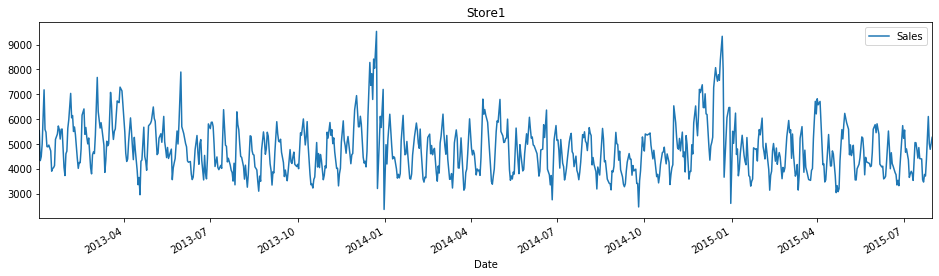

In [12]:
strain = train.loc[(train.Sales>0)&(train.Store==1)].plot(x='Date',
                                                         y='Sales',
                                                         title='Store1',
                                                         figsize=(16, 4)
                                                         )
#每年11，12月份要高于其他月份

# 分析1号店铺6-9月的销量变化

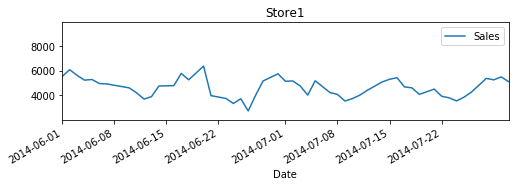

In [13]:
strain = train.loc[(train.Sales>0)&(train.Store==1),
                   ['Date', 'Sales']].plot(x='Date',
                                           y='Sales',
                                           title='Store1',
                                           figsize=(8, 2),
                                           xlim=['2014-6-1',
                                                 '2014-7-31'
                                                ])

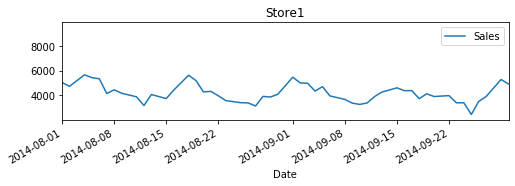

In [14]:
strain = train.loc[(train.Sales>0)&(train.Store==1), ['Date', 'Sales']].plot(x='Date',
                                                          y='Sales',
                                                          title='Store1',
                                                          figsize=(8, 2),
                                                          xlim=['2014-8-1',
                                                                '2014-9-30'
                                                               ])
#从上图的分析中，我们可以看到店铺的销售额是有周期性变化的，
#而且6,7月的销售情况和8，9月的销售情况类似，
#由于我们需要预测2015年8，9月份的前六周，因此我们把6，7月份的前6周用于模型的优化和验证




# 数据预处理

In [15]:
#缺失值处理
#将test中的Open数据补为1，表示处于营业状态。
test['Open'].fillna(1, inplace=True)
#display(test.isnull().sum())

In [16]:
store.fillna(0, inplace=True)
#display(store.isnull().sum())

In [17]:
#分别将train表，test表与store合并
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [18]:
#一共有1115家店铺，每周有7天，留出最近的6周数据作为hold_out数据集进行测试
train = train.sort_values(['Date'], ascending=False)
ho_test = train[: 6*7*1115]
ho_train = train[6*7*1115:]

In [19]:
#ho_train.dtypes

In [20]:
#ho_test.dtypes

In [21]:
#test.dtypes

In [22]:
#由于销售额为0的记录不计入评分，所以只采用销售额>0，店铺为开的数据进行训练
ho_test = ho_test[(ho_test['Open']!=0)&(ho_test['Sales']>0)]
ho_train = ho_test[(ho_test['Open']!=0)&(ho_test['Sales']>0)]
ho_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
679364,747,5,2015-07-31,10708,826,1,1,0,1,c,c,45740.0,8.0,2008.0,0,0.0,0.0,0
702362,772,5,2015-07-31,5224,635,1,1,0,1,d,c,1850.0,0.0,0.0,0,0.0,0.0,0
683890,752,5,2015-07-31,7763,565,1,1,0,1,a,a,970.0,3.0,2013.0,1,31.0,2013.0,"Feb,May,Aug,Nov"
17714,20,5,2015-07-31,9593,974,1,1,0,0,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [23]:
#ho_test.head()

In [24]:
#test.head()

# 特征工程

In [25]:
#特征处理与转化，定义特征函数
def features_create(data):
    #将存在其他字符表示分类的特征转化为数字
    #mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data['Assortment'].replace({'a':1, 'b':2, 'c':3}, inplace=True)
    data['StoreType'].replace({'a':1, 'b':2, 'c':3, 'd':4}, inplace=True) 
    data['StateHoliday'].replace({'0':0, 'a':1}, inplace=True)
        
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    #新增‘CompetitionOpen’和'PrompOpen'特征，
    #表示某天某店铺的竞争对手已营业时间和店铺已促销时间，用月为单位表示
    data['CompetitionOpen'] = 12*(data['Year']-data['CompetitionOpenSinceYear'])+(data['Month']-data['CompetitionOpenSinceMonth'])
    data['PromoOpen'] = 12*(data['Year']-data['Promo2SinceYear'])+(data['WeekOfYear']-data['Promo2SinceWeek'])/4.0
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x : x
                                                        if x > 0 else 0)
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x : x
                                                        if x > 0 else 0)
    
    #将'PromoInterval'特征转化为‘IsPromoMonth’特征
    #表示某天某店铺是否处于促销月, 1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data['Month'].map(month2str)
    data.loc[data['PromoInterval']==0, 'PromoInterval'] = ''
    for interval in data['PromoInterval'].unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[data['monthStr']==month, 'IsPromoMonth'] = 1
    return data

In [26]:
#对ho_train, ho_test以及test进行特征转化
features_create(ho_train)
features_create(ho_test)
features_create(test)
print('Feature creation finished')

Feature creation finished


In [27]:
#ho_train.dtypes

In [28]:
#ho_test.dtypes

In [29]:
#test.dtypes

In [30]:
#删除不需要的特征
ho_train.drop(['Date', 'Customers', 'Open', 'PromoInterval', 'monthStr'],
              axis=1, inplace=True)
ho_test.drop(['Date', 'Customers', 'Open', 'PromoInterval', 'monthStr'],
              axis=1, inplace=True)


In [31]:
#分析训练数据集中特征相关性以及特征与‘Sales’标签相关性
#plt.subplots(figsize=(24,20))
#sns.heatmap(ho_train.corr(), annot=True,
            #vmin=-0.1, vmax=0.1,center=0)

In [32]:
#拆分特征与标签,并将标签取对数处理
ho_xtrain = ho_train.drop(['Sales'], axis=1)
ho_ytrain = np.log1p(ho_train.Sales)

ho_xtest = ho_test.drop(['Sales'],axis=1)
ho_ytest = np.log1p(ho_test.Sales)

In [33]:
ho_xtest.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,31,31,82.0,24187.75,1.0
679364,747,4,1,0,1,3,3,45740.0,8.0,2008.0,0,0.0,0.0,2015,7,31,31,83.0,24187.75,1.0
702362,772,4,1,0,1,4,3,1850.0,0.0,0.0,0,0.0,0.0,2015,7,31,31,24187.0,24187.75,1.0
683890,752,4,1,0,1,1,1,970.0,3.0,2013.0,1,31.0,2013.0,2015,7,31,31,28.0,24.00,1.0
17714,20,4,1,0,0,4,1,2340.0,5.0,2009.0,1,40.0,2014.0,2015,7,31,31,74.0,9.75,1.0


In [34]:
#使test与之前标签对应一致
xtest =test.drop(['Id','Date','Open','PromoInterval','monthStr'],
                 axis = 1)

# 定义评价函数

In [35]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))

#系统自定义函数
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

# 模型构建

In [36]:
#初始模型构建
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 600

In [37]:
#将DMatrix 格式的数据保存成XGBoost的二进制格式，在下次加载时可以提高加载
dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

/usr/local/miniconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [38]:
#模型训练
print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
               early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print("Training time is {:2f} s.".format(end-start))

Train a XGBoost model
[0]	train-rmse:8.02732	eval-rmse:8.02732	train-rmspe:0.999811	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.787	eval-rmse:7.787	train-rmspe:0.999713	eval-rmspe:0.999713
[2]	train-rmse:7.55392	eval-rmse:7.55392	train-rmspe:0.999594	eval-rmspe:0.999594
[3]	train-rmse:7.32785	eval-rmse:7.32785	train-rmspe:0.999448	eval-rmspe:0.999448
[4]	train-rmse:7.10856	eval-rmse:7.10856	train-rmspe:0.999272	eval-rmspe:0.999272
[5]	train-rmse:6.89589	eval-rmse:6.89589	train-rmspe:0.999059	eval-rmspe:0.999059
[6]	train-rmse:6.6896	eval-rmse:6.6896	train-rmspe:0.998806	eval-rmspe:0.998806
[7]	train-rmse:6.48952	eval-rmse:6.48952	train-rmspe:0.998504	eval-rmspe:0.998504
[8]	train-rmse:6.29544	eval-rmse:6.29544	train-rmspe:0.998149	eval-rmspe:0.998149
[9]	train-rmse:6.10723	eval-rmse:6.10723	train-rmspe:0.997733	eval-rmspe:0.997733
[10]	train-rmse:5.

[97]	train-rmse:0.493522	eval-rmse:0.493522	train-rmspe:0.368493	eval-rmspe:0.368493
[98]	train-rmse:0.482315	eval-rmse:0.482315	train-rmspe:0.361913	eval-rmspe:0.361913
[99]	train-rmse:0.471571	eval-rmse:0.471571	train-rmspe:0.355553	eval-rmspe:0.355553
[100]	train-rmse:0.46122	eval-rmse:0.46122	train-rmspe:0.34943	eval-rmspe:0.34943
[101]	train-rmse:0.451185	eval-rmse:0.451185	train-rmspe:0.343455	eval-rmspe:0.343455
[102]	train-rmse:0.441176	eval-rmse:0.441176	train-rmspe:0.337506	eval-rmspe:0.337506
[103]	train-rmse:0.431634	eval-rmse:0.431634	train-rmspe:0.331769	eval-rmspe:0.331769
[104]	train-rmse:0.422471	eval-rmse:0.422471	train-rmspe:0.326284	eval-rmspe:0.326284
[105]	train-rmse:0.413609	eval-rmse:0.413609	train-rmspe:0.320993	eval-rmspe:0.320993
[106]	train-rmse:0.404663	eval-rmse:0.404663	train-rmspe:0.315612	eval-rmspe:0.315612
[107]	train-rmse:0.396578	eval-rmse:0.396578	train-rmspe:0.310712	eval-rmspe:0.310712
[108]	train-rmse:0.388501	eval-rmse:0.388501	train-rmspe:0.30

[193]	train-rmse:0.184627	eval-rmse:0.184627	train-rmspe:0.188628	eval-rmspe:0.188628
[194]	train-rmse:0.18397	eval-rmse:0.18397	train-rmspe:0.188104	eval-rmspe:0.188104
[195]	train-rmse:0.183509	eval-rmse:0.183509	train-rmspe:0.187798	eval-rmspe:0.187798
[196]	train-rmse:0.18265	eval-rmse:0.18265	train-rmspe:0.187112	eval-rmspe:0.187112
[197]	train-rmse:0.182106	eval-rmse:0.182106	train-rmspe:0.186762	eval-rmspe:0.186762
[198]	train-rmse:0.180789	eval-rmse:0.180789	train-rmspe:0.185454	eval-rmspe:0.185454
[199]	train-rmse:0.180567	eval-rmse:0.180567	train-rmspe:0.185398	eval-rmspe:0.185398
[200]	train-rmse:0.180131	eval-rmse:0.180131	train-rmspe:0.18513	eval-rmspe:0.18513
[201]	train-rmse:0.179371	eval-rmse:0.179371	train-rmspe:0.184478	eval-rmspe:0.184478
[202]	train-rmse:0.17905	eval-rmse:0.17905	train-rmspe:0.184275	eval-rmspe:0.184275
[203]	train-rmse:0.178616	eval-rmse:0.178616	train-rmspe:0.183975	eval-rmspe:0.183975
[204]	train-rmse:0.178341	eval-rmse:0.178341	train-rmspe:0.183

[289]	train-rmse:0.137937	eval-rmse:0.137937	train-rmspe:0.144603	eval-rmspe:0.144603
[290]	train-rmse:0.137785	eval-rmse:0.137785	train-rmspe:0.144379	eval-rmspe:0.144379
[291]	train-rmse:0.137674	eval-rmse:0.137674	train-rmspe:0.144263	eval-rmspe:0.144263
[292]	train-rmse:0.137139	eval-rmse:0.137139	train-rmspe:0.143713	eval-rmspe:0.143713
[293]	train-rmse:0.136901	eval-rmse:0.136901	train-rmspe:0.143467	eval-rmspe:0.143467
[294]	train-rmse:0.136556	eval-rmse:0.136556	train-rmspe:0.143108	eval-rmspe:0.143108
[295]	train-rmse:0.136466	eval-rmse:0.136466	train-rmspe:0.143014	eval-rmspe:0.143014
[296]	train-rmse:0.136159	eval-rmse:0.136159	train-rmspe:0.142712	eval-rmspe:0.142712
[297]	train-rmse:0.135848	eval-rmse:0.135848	train-rmspe:0.142402	eval-rmspe:0.142402
[298]	train-rmse:0.135631	eval-rmse:0.135631	train-rmspe:0.142181	eval-rmspe:0.142181
[299]	train-rmse:0.1352	eval-rmse:0.1352	train-rmspe:0.141739	eval-rmspe:0.141739
[300]	train-rmse:0.135017	eval-rmse:0.135017	train-rmspe:0

[385]	train-rmse:0.109611	eval-rmse:0.109611	train-rmspe:0.114484	eval-rmspe:0.114484
[386]	train-rmse:0.109168	eval-rmse:0.109168	train-rmspe:0.114018	eval-rmspe:0.114018
[387]	train-rmse:0.108847	eval-rmse:0.108847	train-rmspe:0.113667	eval-rmspe:0.113667
[388]	train-rmse:0.108614	eval-rmse:0.108614	train-rmspe:0.113403	eval-rmspe:0.113403
[389]	train-rmse:0.108554	eval-rmse:0.108554	train-rmspe:0.113338	eval-rmspe:0.113338
[390]	train-rmse:0.108204	eval-rmse:0.108204	train-rmspe:0.112974	eval-rmspe:0.112974
[391]	train-rmse:0.107972	eval-rmse:0.107972	train-rmspe:0.112725	eval-rmspe:0.112725
[392]	train-rmse:0.107901	eval-rmse:0.107901	train-rmspe:0.112647	eval-rmspe:0.112647
[393]	train-rmse:0.107815	eval-rmse:0.107815	train-rmspe:0.112554	eval-rmspe:0.112554
[394]	train-rmse:0.107647	eval-rmse:0.107647	train-rmspe:0.112383	eval-rmspe:0.112383
[395]	train-rmse:0.107313	eval-rmse:0.107313	train-rmspe:0.111994	eval-rmspe:0.111994
[396]	train-rmse:0.107086	eval-rmse:0.107086	train-rms

[481]	train-rmse:0.092694	eval-rmse:0.092694	train-rmspe:0.096192	eval-rmspe:0.096192
[482]	train-rmse:0.092637	eval-rmse:0.092637	train-rmspe:0.096131	eval-rmspe:0.096131
[483]	train-rmse:0.092453	eval-rmse:0.092453	train-rmspe:0.095929	eval-rmspe:0.095929
[484]	train-rmse:0.092338	eval-rmse:0.092338	train-rmspe:0.095809	eval-rmspe:0.095809
[485]	train-rmse:0.092201	eval-rmse:0.092201	train-rmspe:0.095657	eval-rmspe:0.095657
[486]	train-rmse:0.09208	eval-rmse:0.09208	train-rmspe:0.095524	eval-rmspe:0.095524
[487]	train-rmse:0.09187	eval-rmse:0.09187	train-rmspe:0.095297	eval-rmspe:0.095297
[488]	train-rmse:0.091713	eval-rmse:0.091713	train-rmspe:0.09513	eval-rmspe:0.09513
[489]	train-rmse:0.091521	eval-rmse:0.091521	train-rmspe:0.094873	eval-rmspe:0.094873
[490]	train-rmse:0.091464	eval-rmse:0.091464	train-rmspe:0.094813	eval-rmspe:0.094813
[491]	train-rmse:0.091381	eval-rmse:0.091381	train-rmspe:0.094718	eval-rmspe:0.094718
[492]	train-rmse:0.091162	eval-rmse:0.091162	train-rmspe:0.0

[577]	train-rmse:0.080651	eval-rmse:0.080651	train-rmspe:0.082919	eval-rmspe:0.082919
[578]	train-rmse:0.080501	eval-rmse:0.080501	train-rmspe:0.082758	eval-rmspe:0.082758
[579]	train-rmse:0.080347	eval-rmse:0.080347	train-rmspe:0.082597	eval-rmspe:0.082597
[580]	train-rmse:0.080297	eval-rmse:0.080297	train-rmspe:0.082541	eval-rmspe:0.082541
[581]	train-rmse:0.080251	eval-rmse:0.080251	train-rmspe:0.082495	eval-rmspe:0.082495
[582]	train-rmse:0.080158	eval-rmse:0.080158	train-rmspe:0.082397	eval-rmspe:0.082397
[583]	train-rmse:0.080089	eval-rmse:0.080089	train-rmspe:0.082327	eval-rmspe:0.082327
[584]	train-rmse:0.080001	eval-rmse:0.080001	train-rmspe:0.082237	eval-rmspe:0.082237
[585]	train-rmse:0.079965	eval-rmse:0.079965	train-rmspe:0.082201	eval-rmspe:0.082201
[586]	train-rmse:0.079818	eval-rmse:0.079818	train-rmspe:0.082034	eval-rmspe:0.082034
[587]	train-rmse:0.079688	eval-rmse:0.079688	train-rmspe:0.081903	eval-rmspe:0.081903
[588]	train-rmse:0.079577	eval-rmse:0.079577	train-rms

In [39]:
#采用保留数据集进行检验
print("validating")
ho_xtest.sort_index(inplace=True)
ho_ytest.sort_index(inplace=True)
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print("RMSPE: {:.6f}".format(error))

validating
RMSPE: 0.080491


# 结果分析

In [40]:
#构建保留数据集预测结果
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,...,31,31,82.0,24187.75,1.0,8.568646,8.579742,1.001295,0.001295,0.998707
1,1,3,1,0,1,3,1,1270.0,9.0,2008.0,...,30,31,82.0,24187.75,1.0,8.521384,8.489620,0.996272,0.003728,1.003742
2,1,2,1,0,1,3,1,1270.0,9.0,2008.0,...,29,31,82.0,24187.75,1.0,8.472823,8.479414,1.000778,0.000778,0.999223
3,1,1,1,0,1,3,1,1270.0,9.0,2008.0,...,28,31,82.0,24187.75,1.0,8.519590,8.549173,1.003472,0.003472,0.996540
4,1,0,1,0,1,3,1,1270.0,9.0,2008.0,...,27,31,82.0,24187.75,1.0,8.716536,8.645967,0.991904,0.008096,1.008162


Mean Ratio of prediction and real sales data is 1.000200092018882: store all
Mean Ratio of predition and real sales data is 1.0004151293569692: store 111
Mean Ratio of predition and real sales data is 0.997125945045729: store 606
Mean Ratio of predition and real sales data is 1.000501241455753: store 716


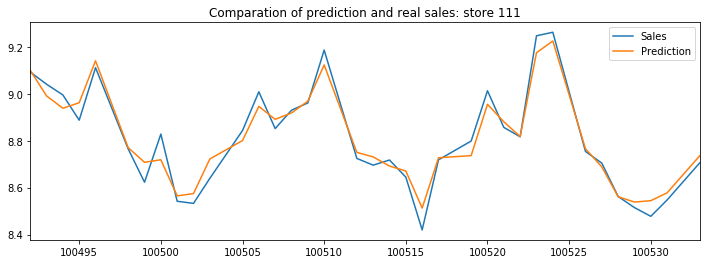

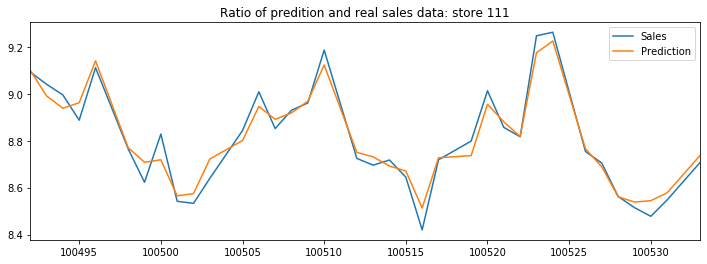

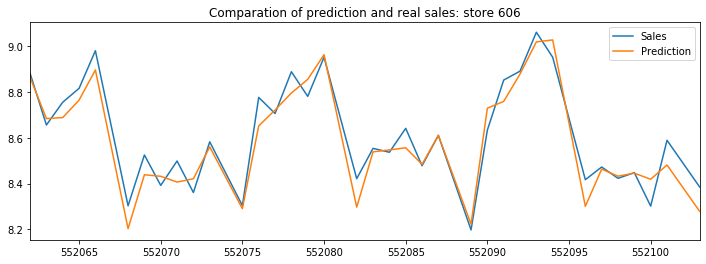

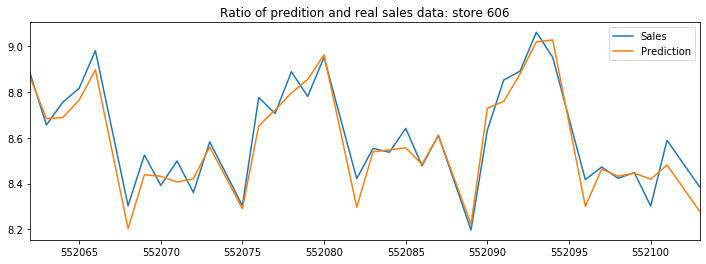

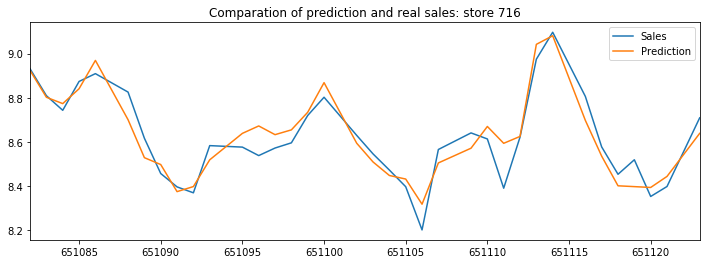

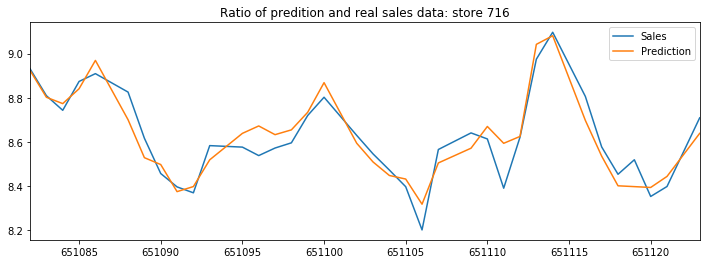

In [41]:
#分析保留数据集中任意三个店铺的预测结果
col_1 = ['Sales', 'Prediction']
col_2 = ['Ratio']
L = np.random.randint(low=1, high=1115, size=3)
print("Mean Ratio of prediction and real sales data is {}: store all"
      .format(res['Ratio'].mean()))

for i in L:
    s1 = pd.DataFrame(res[res['Store'] == i], columns=col_1)
    s2 = pd.DataFrame(res[res['Store'] == i], columns=col_2)
    s1.plot(title='Comparation of prediction and real sales: store {}'
           .format(i), figsize=(12, 4))
    s1.plot(title='Ratio of predition and real sales data: store {}'
           .format(i), figsize=(12, 4))
    print('Mean Ratio of predition and real sales data is {}: store {}'
          .format(s2['Ratio'].mean(), i))
    

In [42]:
#分析偏差最大的10个预测结果
res.sort_values(['Error'], ascending=False, inplace=True)
res[:10]

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
264207,292,4,0,0,0,1,1,1100.0,6.0,2009.0,...,10,28,73.0,24187.00,1.0,6.920672,8.044688,1.162414,0.162414,0.860278
711449,782,4,0,0,0,3,3,5390.0,8.0,2003.0,...,26,26,142.0,42.25,1.0,7.260523,8.007283,1.102852,0.102852,0.906740
264213,292,5,0,0,0,1,1,1100.0,6.0,2009.0,...,4,27,73.0,24186.75,1.0,7.406711,8.004181,1.080666,0.080666,0.925355
456286,501,5,0,0,0,1,3,1620.0,9.0,2006.0,...,25,30,106.0,24187.50,1.0,7.360104,7.943919,1.079322,0.079322,0.926508
937688,1029,5,0,0,0,1,1,1590.0,3.0,2006.0,...,20,25,111.0,24186.25,1.0,7.338888,7.916481,1.078703,0.078703,0.927039
937667,1029,5,0,0,0,1,1,1590.0,3.0,2006.0,...,11,28,112.0,24187.00,1.0,7.325149,7.883104,1.076170,0.076170,0.929221
165039,183,4,0,0,0,1,1,9670.0,0.0,0.0,...,26,26,24186.0,24186.50,1.0,9.579418,8.850098,0.923866,0.076134,1.082408
818909,899,5,0,0,0,4,1,2590.0,0.0,0.0,...,20,25,24186.0,63.00,1.0,7.521318,8.066490,1.072484,0.072484,0.932415
440257,483,5,0,0,0,1,3,2310.0,9.0,2011.0,...,18,29,46.0,64.00,1.0,7.310550,7.819795,1.069659,0.069659,0.934878
264218,292,0,1,0,0,1,1,1100.0,6.0,2009.0,...,29,27,72.0,24186.75,1.0,10.280622,9.602065,0.933997,0.066003,1.070668


# 模型优化

In [43]:
#从分析结果来看，我们的初始模型已经可以比较好的预测hold_out数据集的销售趋势
#但相对于真实值，我们模型的预测值整体要偏高一些
#从对偏差数据分析来看，偏差最大的三个数据也是明显偏高
#因此我们可以以hold_out数据集为标准对模型进行偏差校正

7.1偏差整体校正优化

Weight correction
RMSPE for 0.990:0.110329
RMSPE for 0.991:0.104919
RMSPE for 0.992:0.099831
RMSPE for 0.993:0.095135
RMSPE for 0.994:0.090911
RMSPE for 0.995:0.087248
RMSPE for 0.996:0.084241
RMSPE for 0.997:0.081985
RMSPE for 0.998:0.080566
RMSPE for 0.999:0.080054
RMSPE for 1.000:0.080491
RMSPE for 1.001:0.081886
RMSPE for 1.002:0.084216
RMSPE for 1.003:0.087431
RMSPE for 1.004:0.091461
RMSPE for 1.005:0.096226
RMSPE for 1.006:0.101645
RMSPE for 1.007:0.107641
RMSPE for 1.008:0.114143
RMSPE for 1.009:0.121090
Best weight for Score:0.999    0.080054
dtype: float64


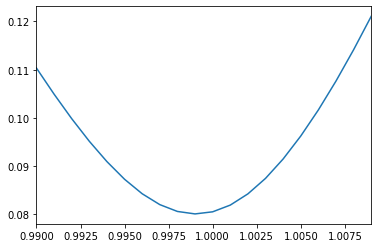

In [44]:
print("Weight correction")
W = [(0.990+(i/1000)) for i in range(20)]
S = []
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w, error))
    S.append(error)
    
Score = pd.Series(S, index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print('Best weight for Score:{}'.format(BS))

In [45]:
#当校正系数为0.999时，hold_out集的RMSPE得分最低:0.080054

7.2细致校正

In [46]:
#以不同的店铺分组进行细致校正，每个店铺分别计算可以取得最佳RMSPE得分的校正系数
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())


In [47]:
#计算校正后整体数据的RMSPE得分
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))
error

RMSPE for weight corretion 0.074398


0.07439820100243298

In [48]:
#用初始和校正后的模型对训练数据集进行预测
print("Make predictions on the test set")
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)
 
#初始模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("origin.csv", index=False)
 
#整体校正模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*0.995)})
result.to_csv("general.csv", index=False)
 
#细致校正模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*W_test)})
result.to_csv("detail.csv", index=False)

Make predictions on the test set


训练融合模型

In [49]:
#ho_test:67月
#test:89月

print("Train an new ensemble XGBoost model")
start = time()
rounds = 10
preds_ho = np.zeros((len(ho_xtest.index), rounds))
preds_test = np.zeros((len(test.index), rounds))
B=[]
for r in range(rounds):
    print('round {}:'.format(r+1))
    
    params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": r+1
          }
    num_boost_round = 600
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                    early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
    
    yhat = gbm.predict(xgb.DMatrix(ho_xtest))
    
    L=range(1115)
    W_ho=[]
    W_test=[]
    for i in L:
        s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
        s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
        W1=[(0.990+(i/1000)) for i in range(20)]
        S =[]
        for w in W1:
            error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
            S.append(error)
        Score = pd.Series(S,index=W1)
        BS = Score[Score.values == Score.values.min()]
        a=np.array(BS.index.values)
        b_ho=a.repeat(len(s1))
        b_test=a.repeat(len(s2))
        W_ho.extend(b_ho.tolist())
        W_test.extend(b_test.tolist())
    
 
    yhat_ho = yhat*W_ho
    yhat_test =gbm.predict(xgb.DMatrix(xtest))*W_test
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_ho))
    B.append(error)
    preds_ho[:, r] = yhat_ho
    preds_test[:, r] = yhat_test
    print('round {} end'.format(r+1))
    
end = time()
time_elapsed = end-start
print('Training is end')
print('Training time is {} h.'.format(time_elapsed/3600))


Train an new ensemble XGBoost model
round 1:
[0]	train-rmse:8.02734	eval-rmse:8.02734	train-rmspe:0.999811	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78705	eval-rmse:7.78705	train-rmspe:0.999713	eval-rmspe:0.999713
[2]	train-rmse:7.55398	eval-rmse:7.55398	train-rmspe:0.999594	eval-rmspe:0.999594
[3]	train-rmse:7.32792	eval-rmse:7.32792	train-rmspe:0.999448	eval-rmspe:0.999448
[4]	train-rmse:7.10867	eval-rmse:7.10867	train-rmspe:0.999272	eval-rmspe:0.999272
[5]	train-rmse:6.89601	eval-rmse:6.89601	train-rmspe:0.999059	eval-rmspe:0.999059
[6]	train-rmse:6.68973	eval-rmse:6.68973	train-rmspe:0.998806	eval-rmspe:0.998806
[7]	train-rmse:6.48967	eval-rmse:6.48967	train-rmspe:0.998505	eval-rmspe:0.998505
[8]	train-rmse:6.29565	eval-rmse:6.29565	train-rmspe:0.998149	eval-rmspe:0.998149
[9]	train-rmse:6.10743	eval-rmse:6.10743	train-rmspe:0.997732	eval-rmsp

[97]	train-rmse:0.491813	eval-rmse:0.491813	train-rmspe:0.367767	eval-rmspe:0.367767
[98]	train-rmse:0.480103	eval-rmse:0.480103	train-rmspe:0.360981	eval-rmspe:0.360981
[99]	train-rmse:0.469486	eval-rmse:0.469486	train-rmspe:0.35468	eval-rmspe:0.35468
[100]	train-rmse:0.4589	eval-rmse:0.4589	train-rmspe:0.348375	eval-rmspe:0.348375
[101]	train-rmse:0.448976	eval-rmse:0.448976	train-rmspe:0.342424	eval-rmspe:0.342424
[102]	train-rmse:0.439494	eval-rmse:0.439494	train-rmspe:0.336707	eval-rmspe:0.336707
[103]	train-rmse:0.430034	eval-rmse:0.430034	train-rmspe:0.331024	eval-rmspe:0.331024
[104]	train-rmse:0.421251	eval-rmse:0.421251	train-rmspe:0.325717	eval-rmspe:0.325717
[105]	train-rmse:0.41247	eval-rmse:0.41247	train-rmspe:0.320427	eval-rmspe:0.320427
[106]	train-rmse:0.4042	eval-rmse:0.4042	train-rmspe:0.315399	eval-rmspe:0.315399
[107]	train-rmse:0.395858	eval-rmse:0.395858	train-rmspe:0.310371	eval-rmspe:0.310371
[108]	train-rmse:0.388215	eval-rmse:0.388215	train-rmspe:0.305732	eva

[193]	train-rmse:0.181041	eval-rmse:0.181041	train-rmspe:0.184679	eval-rmspe:0.184679
[194]	train-rmse:0.180758	eval-rmse:0.180758	train-rmspe:0.184575	eval-rmspe:0.184575
[195]	train-rmse:0.179827	eval-rmse:0.179827	train-rmspe:0.183778	eval-rmspe:0.183778
[196]	train-rmse:0.179405	eval-rmse:0.179405	train-rmspe:0.183506	eval-rmspe:0.183506
[197]	train-rmse:0.178665	eval-rmse:0.178665	train-rmspe:0.182932	eval-rmspe:0.182932
[198]	train-rmse:0.177574	eval-rmse:0.177574	train-rmspe:0.181962	eval-rmspe:0.181962
[199]	train-rmse:0.177131	eval-rmse:0.177131	train-rmspe:0.181649	eval-rmspe:0.181649
[200]	train-rmse:0.176673	eval-rmse:0.176673	train-rmspe:0.181327	eval-rmspe:0.181327
[201]	train-rmse:0.175898	eval-rmse:0.175898	train-rmspe:0.180705	eval-rmspe:0.180705
[202]	train-rmse:0.175589	eval-rmse:0.175589	train-rmspe:0.180515	eval-rmspe:0.180515
[203]	train-rmse:0.174746	eval-rmse:0.174746	train-rmspe:0.179778	eval-rmspe:0.179778
[204]	train-rmse:0.174306	eval-rmse:0.174306	train-rms

[289]	train-rmse:0.136788	eval-rmse:0.136788	train-rmspe:0.143318	eval-rmspe:0.143318
[290]	train-rmse:0.136622	eval-rmse:0.136622	train-rmspe:0.143157	eval-rmspe:0.143157
[291]	train-rmse:0.136041	eval-rmse:0.136041	train-rmspe:0.142515	eval-rmspe:0.142515
[292]	train-rmse:0.135644	eval-rmse:0.135644	train-rmspe:0.142123	eval-rmspe:0.142123
[293]	train-rmse:0.135432	eval-rmse:0.135432	train-rmspe:0.141903	eval-rmspe:0.141903
[294]	train-rmse:0.134957	eval-rmse:0.134957	train-rmspe:0.141392	eval-rmspe:0.141392
[295]	train-rmse:0.134854	eval-rmse:0.134854	train-rmspe:0.141284	eval-rmspe:0.141284
[296]	train-rmse:0.134572	eval-rmse:0.134572	train-rmspe:0.14098	eval-rmspe:0.14098
[297]	train-rmse:0.134141	eval-rmse:0.134141	train-rmspe:0.140527	eval-rmspe:0.140527
[298]	train-rmse:0.133625	eval-rmse:0.133625	train-rmspe:0.140002	eval-rmspe:0.140002
[299]	train-rmse:0.133315	eval-rmse:0.133315	train-rmspe:0.139682	eval-rmspe:0.139682
[300]	train-rmse:0.133242	eval-rmse:0.133242	train-rmspe

[385]	train-rmse:0.109155	eval-rmse:0.109155	train-rmspe:0.113593	eval-rmspe:0.113593
[386]	train-rmse:0.10888	eval-rmse:0.10888	train-rmspe:0.113302	eval-rmspe:0.113302
[387]	train-rmse:0.108719	eval-rmse:0.108719	train-rmspe:0.113131	eval-rmspe:0.113131
[388]	train-rmse:0.108408	eval-rmse:0.108408	train-rmspe:0.112788	eval-rmspe:0.112788
[389]	train-rmse:0.108301	eval-rmse:0.108301	train-rmspe:0.112679	eval-rmspe:0.112679
[390]	train-rmse:0.108163	eval-rmse:0.108163	train-rmspe:0.11253	eval-rmspe:0.11253
[391]	train-rmse:0.107848	eval-rmse:0.107848	train-rmspe:0.112187	eval-rmspe:0.112187
[392]	train-rmse:0.107469	eval-rmse:0.107469	train-rmspe:0.111759	eval-rmspe:0.111759
[393]	train-rmse:0.107209	eval-rmse:0.107209	train-rmspe:0.111482	eval-rmspe:0.111482
[394]	train-rmse:0.106979	eval-rmse:0.106979	train-rmspe:0.111242	eval-rmspe:0.111242
[395]	train-rmse:0.106854	eval-rmse:0.106854	train-rmspe:0.111121	eval-rmspe:0.111121
[396]	train-rmse:0.10663	eval-rmse:0.10663	train-rmspe:0.1

[481]	train-rmse:0.092238	eval-rmse:0.092238	train-rmspe:0.095405	eval-rmspe:0.095405
[482]	train-rmse:0.092118	eval-rmse:0.092118	train-rmspe:0.095278	eval-rmspe:0.095278
[483]	train-rmse:0.091893	eval-rmse:0.091893	train-rmspe:0.09504	eval-rmspe:0.09504
[484]	train-rmse:0.091752	eval-rmse:0.091752	train-rmspe:0.094889	eval-rmspe:0.094889
[485]	train-rmse:0.091544	eval-rmse:0.091544	train-rmspe:0.094656	eval-rmspe:0.094656
[486]	train-rmse:0.091411	eval-rmse:0.091411	train-rmspe:0.094522	eval-rmspe:0.094522
[487]	train-rmse:0.091293	eval-rmse:0.091293	train-rmspe:0.094402	eval-rmspe:0.094402
[488]	train-rmse:0.091153	eval-rmse:0.091153	train-rmspe:0.094259	eval-rmspe:0.094259
[489]	train-rmse:0.090817	eval-rmse:0.090817	train-rmspe:0.093875	eval-rmspe:0.093875
[490]	train-rmse:0.090685	eval-rmse:0.090685	train-rmspe:0.09374	eval-rmspe:0.09374
[491]	train-rmse:0.090613	eval-rmse:0.090613	train-rmspe:0.093667	eval-rmspe:0.093667
[492]	train-rmse:0.090568	eval-rmse:0.090568	train-rmspe:0

[577]	train-rmse:0.080454	eval-rmse:0.080454	train-rmspe:0.082506	eval-rmspe:0.082506
[578]	train-rmse:0.080355	eval-rmse:0.080355	train-rmspe:0.082405	eval-rmspe:0.082405
[579]	train-rmse:0.080273	eval-rmse:0.080273	train-rmspe:0.082317	eval-rmspe:0.082317
[580]	train-rmse:0.080068	eval-rmse:0.080068	train-rmspe:0.082079	eval-rmspe:0.082079
[581]	train-rmse:0.079916	eval-rmse:0.079916	train-rmspe:0.081894	eval-rmspe:0.081894
[582]	train-rmse:0.079747	eval-rmse:0.079747	train-rmspe:0.081705	eval-rmspe:0.081705
[583]	train-rmse:0.079514	eval-rmse:0.079514	train-rmspe:0.081458	eval-rmspe:0.081458
[584]	train-rmse:0.079397	eval-rmse:0.079397	train-rmspe:0.081334	eval-rmspe:0.081334
[585]	train-rmse:0.079265	eval-rmse:0.079265	train-rmspe:0.081199	eval-rmspe:0.081199
[586]	train-rmse:0.079153	eval-rmse:0.079153	train-rmspe:0.081074	eval-rmspe:0.081074
[587]	train-rmse:0.079106	eval-rmse:0.079106	train-rmspe:0.081027	eval-rmspe:0.081027
[588]	train-rmse:0.078993	eval-rmse:0.078993	train-rms

[74]	train-rmse:0.891074	eval-rmse:0.891074	train-rmspe:0.568108	eval-rmspe:0.568108
[75]	train-rmse:0.866723	eval-rmse:0.866723	train-rmspe:0.557787	eval-rmspe:0.557787
[76]	train-rmse:0.843327	eval-rmse:0.843327	train-rmspe:0.547556	eval-rmspe:0.547556
[77]	train-rmse:0.820705	eval-rmse:0.820705	train-rmspe:0.537444	eval-rmspe:0.537444
[78]	train-rmse:0.798699	eval-rmse:0.798699	train-rmspe:0.527454	eval-rmspe:0.527454
[79]	train-rmse:0.777395	eval-rmse:0.777395	train-rmspe:0.517611	eval-rmspe:0.517611
[80]	train-rmse:0.756428	eval-rmse:0.756428	train-rmspe:0.507894	eval-rmspe:0.507894
[81]	train-rmse:0.736029	eval-rmse:0.736029	train-rmspe:0.498306	eval-rmspe:0.498306
[82]	train-rmse:0.716604	eval-rmse:0.716604	train-rmspe:0.488884	eval-rmspe:0.488884
[83]	train-rmse:0.69791	eval-rmse:0.69791	train-rmspe:0.479615	eval-rmspe:0.479615
[84]	train-rmse:0.67989	eval-rmse:0.67989	train-rmspe:0.470537	eval-rmspe:0.470537
[85]	train-rmse:0.662306	eval-rmse:0.662306	train-rmspe:0.461553	eval

[170]	train-rmse:0.200335	eval-rmse:0.200335	train-rmspe:0.197985	eval-rmspe:0.197985
[171]	train-rmse:0.19949	eval-rmse:0.19949	train-rmspe:0.197539	eval-rmspe:0.197539
[172]	train-rmse:0.198709	eval-rmse:0.198709	train-rmspe:0.197135	eval-rmspe:0.197135
[173]	train-rmse:0.197815	eval-rmse:0.197815	train-rmspe:0.196595	eval-rmspe:0.196595
[174]	train-rmse:0.196979	eval-rmse:0.196979	train-rmspe:0.196138	eval-rmspe:0.196138
[175]	train-rmse:0.196303	eval-rmse:0.196303	train-rmspe:0.195796	eval-rmspe:0.195796
[176]	train-rmse:0.195672	eval-rmse:0.195672	train-rmspe:0.1955	eval-rmspe:0.1955
[177]	train-rmse:0.195161	eval-rmse:0.195161	train-rmspe:0.195315	eval-rmspe:0.195315
[178]	train-rmse:0.193395	eval-rmse:0.193395	train-rmspe:0.19382	eval-rmspe:0.19382
[179]	train-rmse:0.192491	eval-rmse:0.192491	train-rmspe:0.193195	eval-rmspe:0.193195
[180]	train-rmse:0.191777	eval-rmse:0.191777	train-rmspe:0.192737	eval-rmspe:0.192737
[181]	train-rmse:0.191176	eval-rmse:0.191176	train-rmspe:0.192

[266]	train-rmse:0.141585	eval-rmse:0.141585	train-rmspe:0.147582	eval-rmspe:0.147582
[267]	train-rmse:0.141067	eval-rmse:0.141067	train-rmspe:0.147034	eval-rmspe:0.147034
[268]	train-rmse:0.140737	eval-rmse:0.140737	train-rmspe:0.146682	eval-rmspe:0.146682
[269]	train-rmse:0.140114	eval-rmse:0.140114	train-rmspe:0.146075	eval-rmspe:0.146075
[270]	train-rmse:0.139449	eval-rmse:0.139449	train-rmspe:0.145371	eval-rmspe:0.145371
[271]	train-rmse:0.139123	eval-rmse:0.139123	train-rmspe:0.145039	eval-rmspe:0.145039
[272]	train-rmse:0.138185	eval-rmse:0.138185	train-rmspe:0.144052	eval-rmspe:0.144052
[273]	train-rmse:0.137731	eval-rmse:0.137731	train-rmspe:0.143577	eval-rmspe:0.143577
[274]	train-rmse:0.137306	eval-rmse:0.137306	train-rmspe:0.143157	eval-rmspe:0.143157
[275]	train-rmse:0.137085	eval-rmse:0.137085	train-rmspe:0.142927	eval-rmspe:0.142927
[276]	train-rmse:0.136632	eval-rmse:0.136632	train-rmspe:0.142449	eval-rmspe:0.142449
[277]	train-rmse:0.136365	eval-rmse:0.136365	train-rms

[362]	train-rmse:0.113211	eval-rmse:0.113211	train-rmspe:0.117625	eval-rmspe:0.117625
[363]	train-rmse:0.113028	eval-rmse:0.113028	train-rmspe:0.117426	eval-rmspe:0.117426
[364]	train-rmse:0.112887	eval-rmse:0.112887	train-rmspe:0.117275	eval-rmspe:0.117275
[365]	train-rmse:0.112514	eval-rmse:0.112514	train-rmspe:0.116887	eval-rmspe:0.116887
[366]	train-rmse:0.11224	eval-rmse:0.11224	train-rmspe:0.116598	eval-rmspe:0.116598
[367]	train-rmse:0.111866	eval-rmse:0.111866	train-rmspe:0.116173	eval-rmspe:0.116173
[368]	train-rmse:0.111574	eval-rmse:0.111574	train-rmspe:0.11586	eval-rmspe:0.11586
[369]	train-rmse:0.111173	eval-rmse:0.111173	train-rmspe:0.11544	eval-rmspe:0.11544
[370]	train-rmse:0.110796	eval-rmse:0.110796	train-rmspe:0.115029	eval-rmspe:0.115029
[371]	train-rmse:0.110493	eval-rmse:0.110493	train-rmspe:0.114713	eval-rmspe:0.114713
[372]	train-rmse:0.110338	eval-rmse:0.110338	train-rmspe:0.114535	eval-rmspe:0.114535
[373]	train-rmse:0.110273	eval-rmse:0.110273	train-rmspe:0.1

[458]	train-rmse:0.095094	eval-rmse:0.095094	train-rmspe:0.09827	eval-rmspe:0.09827
[459]	train-rmse:0.094902	eval-rmse:0.094902	train-rmspe:0.098069	eval-rmspe:0.098069
[460]	train-rmse:0.094792	eval-rmse:0.094792	train-rmspe:0.097958	eval-rmspe:0.097958
[461]	train-rmse:0.094613	eval-rmse:0.094613	train-rmspe:0.097762	eval-rmspe:0.097762
[462]	train-rmse:0.094537	eval-rmse:0.094537	train-rmspe:0.097682	eval-rmspe:0.097682
[463]	train-rmse:0.094311	eval-rmse:0.094311	train-rmspe:0.097434	eval-rmspe:0.097434
[464]	train-rmse:0.094228	eval-rmse:0.094228	train-rmspe:0.097351	eval-rmspe:0.097351
[465]	train-rmse:0.09399	eval-rmse:0.09399	train-rmspe:0.097108	eval-rmspe:0.097108
[466]	train-rmse:0.093926	eval-rmse:0.093926	train-rmspe:0.097038	eval-rmspe:0.097038
[467]	train-rmse:0.093877	eval-rmse:0.093877	train-rmspe:0.096986	eval-rmspe:0.096986
[468]	train-rmse:0.093746	eval-rmse:0.093746	train-rmspe:0.096852	eval-rmspe:0.096852
[469]	train-rmse:0.093563	eval-rmse:0.093563	train-rmspe:0

[554]	train-rmse:0.083206	eval-rmse:0.083206	train-rmspe:0.085549	eval-rmspe:0.085549
[555]	train-rmse:0.08309	eval-rmse:0.08309	train-rmspe:0.085436	eval-rmspe:0.085436
[556]	train-rmse:0.08294	eval-rmse:0.08294	train-rmspe:0.085241	eval-rmspe:0.085241
[557]	train-rmse:0.082787	eval-rmse:0.082787	train-rmspe:0.085083	eval-rmspe:0.085083
[558]	train-rmse:0.08273	eval-rmse:0.08273	train-rmspe:0.085021	eval-rmspe:0.085021
[559]	train-rmse:0.082618	eval-rmse:0.082618	train-rmspe:0.084905	eval-rmspe:0.084905
[560]	train-rmse:0.082571	eval-rmse:0.082571	train-rmspe:0.084855	eval-rmspe:0.084855
[561]	train-rmse:0.082503	eval-rmse:0.082503	train-rmspe:0.084787	eval-rmspe:0.084787
[562]	train-rmse:0.082347	eval-rmse:0.082347	train-rmspe:0.084622	eval-rmspe:0.084622
[563]	train-rmse:0.082245	eval-rmse:0.082245	train-rmspe:0.084519	eval-rmspe:0.084519
[564]	train-rmse:0.082064	eval-rmse:0.082064	train-rmspe:0.084321	eval-rmspe:0.084321
[565]	train-rmse:0.081953	eval-rmse:0.081953	train-rmspe:0.0

[50]	train-rmse:1.78063	eval-rmse:1.78063	train-rmspe:0.819219	eval-rmspe:0.819219
[51]	train-rmse:1.72877	eval-rmse:1.72877	train-rmspe:0.809755	eval-rmspe:0.809755
[52]	train-rmse:1.67854	eval-rmse:1.67854	train-rmspe:0.80011	eval-rmspe:0.80011
[53]	train-rmse:1.6298	eval-rmse:1.6298	train-rmspe:0.790308	eval-rmspe:0.790308
[54]	train-rmse:1.58251	eval-rmse:1.58251	train-rmspe:0.780379	eval-rmspe:0.780379
[55]	train-rmse:1.53682	eval-rmse:1.53682	train-rmspe:0.77021	eval-rmspe:0.77021
[56]	train-rmse:1.49259	eval-rmse:1.49259	train-rmspe:0.759898	eval-rmspe:0.759898
[57]	train-rmse:1.44955	eval-rmse:1.44955	train-rmspe:0.749576	eval-rmspe:0.749576
[58]	train-rmse:1.4079	eval-rmse:1.4079	train-rmspe:0.739093	eval-rmspe:0.739093
[59]	train-rmse:1.36744	eval-rmse:1.36744	train-rmspe:0.728559	eval-rmspe:0.728559
[60]	train-rmse:1.32843	eval-rmse:1.32843	train-rmspe:0.717867	eval-rmspe:0.717867
[61]	train-rmse:1.29058	eval-rmse:1.29058	train-rmspe:0.707165	eval-rmspe:0.707165
[62]	train-r

[147]	train-rmse:0.234243	eval-rmse:0.234243	train-rmspe:0.217661	eval-rmspe:0.217661
[148]	train-rmse:0.232613	eval-rmse:0.232613	train-rmspe:0.216856	eval-rmspe:0.216856
[149]	train-rmse:0.231141	eval-rmse:0.231141	train-rmspe:0.216193	eval-rmspe:0.216193
[150]	train-rmse:0.229241	eval-rmse:0.229241	train-rmspe:0.215139	eval-rmspe:0.215139
[151]	train-rmse:0.228129	eval-rmse:0.228129	train-rmspe:0.214827	eval-rmspe:0.214827
[152]	train-rmse:0.226754	eval-rmse:0.226754	train-rmspe:0.21427	eval-rmspe:0.21427
[153]	train-rmse:0.225278	eval-rmse:0.225278	train-rmspe:0.213561	eval-rmspe:0.213561
[154]	train-rmse:0.224183	eval-rmse:0.224183	train-rmspe:0.213173	eval-rmspe:0.213173
[155]	train-rmse:0.223103	eval-rmse:0.223103	train-rmspe:0.212793	eval-rmspe:0.212793
[156]	train-rmse:0.221918	eval-rmse:0.221918	train-rmspe:0.212244	eval-rmspe:0.212244
[157]	train-rmse:0.220561	eval-rmse:0.220561	train-rmspe:0.211556	eval-rmspe:0.211556
[158]	train-rmse:0.219365	eval-rmse:0.219365	train-rmspe

[243]	train-rmse:0.161201	eval-rmse:0.161201	train-rmspe:0.168355	eval-rmspe:0.168355
[244]	train-rmse:0.160074	eval-rmse:0.160074	train-rmspe:0.167213	eval-rmspe:0.167213
[245]	train-rmse:0.159803	eval-rmse:0.159803	train-rmspe:0.166985	eval-rmspe:0.166985
[246]	train-rmse:0.15956	eval-rmse:0.15956	train-rmspe:0.166748	eval-rmspe:0.166748
[247]	train-rmse:0.159327	eval-rmse:0.159327	train-rmspe:0.166549	eval-rmspe:0.166549
[248]	train-rmse:0.158885	eval-rmse:0.158885	train-rmspe:0.166127	eval-rmspe:0.166127
[249]	train-rmse:0.15851	eval-rmse:0.15851	train-rmspe:0.16577	eval-rmspe:0.16577
[250]	train-rmse:0.15832	eval-rmse:0.15832	train-rmspe:0.165598	eval-rmspe:0.165598
[251]	train-rmse:0.157532	eval-rmse:0.157532	train-rmspe:0.164794	eval-rmspe:0.164794
[252]	train-rmse:0.157034	eval-rmse:0.157034	train-rmspe:0.164255	eval-rmspe:0.164255
[253]	train-rmse:0.15655	eval-rmse:0.15655	train-rmspe:0.163739	eval-rmspe:0.163739
[254]	train-rmse:0.156209	eval-rmse:0.156209	train-rmspe:0.16340

[339]	train-rmse:0.12611	eval-rmse:0.12611	train-rmspe:0.132068	eval-rmspe:0.132068
[340]	train-rmse:0.126062	eval-rmse:0.126062	train-rmspe:0.132021	eval-rmspe:0.132021
[341]	train-rmse:0.125644	eval-rmse:0.125644	train-rmspe:0.131569	eval-rmspe:0.131569
[342]	train-rmse:0.125248	eval-rmse:0.125248	train-rmspe:0.131155	eval-rmspe:0.131155
[343]	train-rmse:0.124729	eval-rmse:0.124729	train-rmspe:0.130592	eval-rmspe:0.130592
[344]	train-rmse:0.124463	eval-rmse:0.124463	train-rmspe:0.130329	eval-rmspe:0.130329
[345]	train-rmse:0.124201	eval-rmse:0.124201	train-rmspe:0.130065	eval-rmspe:0.130065
[346]	train-rmse:0.123655	eval-rmse:0.123655	train-rmspe:0.129468	eval-rmspe:0.129468
[347]	train-rmse:0.123464	eval-rmse:0.123464	train-rmspe:0.129272	eval-rmspe:0.129272
[348]	train-rmse:0.123089	eval-rmse:0.123089	train-rmspe:0.128865	eval-rmspe:0.128865
[349]	train-rmse:0.122879	eval-rmse:0.122879	train-rmspe:0.128604	eval-rmspe:0.128604
[350]	train-rmse:0.122715	eval-rmse:0.122715	train-rmspe

[435]	train-rmse:0.103506	eval-rmse:0.103506	train-rmspe:0.107644	eval-rmspe:0.107644
[436]	train-rmse:0.103399	eval-rmse:0.103399	train-rmspe:0.107534	eval-rmspe:0.107534
[437]	train-rmse:0.103085	eval-rmse:0.103085	train-rmspe:0.107205	eval-rmspe:0.107205
[438]	train-rmse:0.103048	eval-rmse:0.103048	train-rmspe:0.107166	eval-rmspe:0.107166
[439]	train-rmse:0.102855	eval-rmse:0.102855	train-rmspe:0.106965	eval-rmspe:0.106965
[440]	train-rmse:0.102519	eval-rmse:0.102519	train-rmspe:0.106574	eval-rmspe:0.106574
[441]	train-rmse:0.10235	eval-rmse:0.10235	train-rmspe:0.106388	eval-rmspe:0.106388
[442]	train-rmse:0.101983	eval-rmse:0.101983	train-rmspe:0.106007	eval-rmspe:0.106007
[443]	train-rmse:0.101839	eval-rmse:0.101839	train-rmspe:0.105865	eval-rmspe:0.105865
[444]	train-rmse:0.101574	eval-rmse:0.101574	train-rmspe:0.105589	eval-rmspe:0.105589
[445]	train-rmse:0.101472	eval-rmse:0.101472	train-rmspe:0.105433	eval-rmspe:0.105433
[446]	train-rmse:0.101173	eval-rmse:0.101173	train-rmspe

[531]	train-rmse:0.088653	eval-rmse:0.088653	train-rmspe:0.091576	eval-rmspe:0.091576
[532]	train-rmse:0.088532	eval-rmse:0.088532	train-rmspe:0.091446	eval-rmspe:0.091446
[533]	train-rmse:0.088419	eval-rmse:0.088419	train-rmspe:0.091329	eval-rmspe:0.091329
[534]	train-rmse:0.088355	eval-rmse:0.088355	train-rmspe:0.09126	eval-rmspe:0.09126
[535]	train-rmse:0.088282	eval-rmse:0.088282	train-rmspe:0.091184	eval-rmspe:0.091184
[536]	train-rmse:0.088	eval-rmse:0.088	train-rmspe:0.090867	eval-rmspe:0.090867
[537]	train-rmse:0.087898	eval-rmse:0.087898	train-rmspe:0.090759	eval-rmspe:0.090759
[538]	train-rmse:0.087819	eval-rmse:0.087819	train-rmspe:0.09067	eval-rmspe:0.09067
[539]	train-rmse:0.087658	eval-rmse:0.087658	train-rmspe:0.090484	eval-rmspe:0.090484
[540]	train-rmse:0.087441	eval-rmse:0.087441	train-rmspe:0.090243	eval-rmspe:0.090243
[541]	train-rmse:0.087376	eval-rmse:0.087376	train-rmspe:0.090177	eval-rmspe:0.090177
[542]	train-rmse:0.087325	eval-rmse:0.087325	train-rmspe:0.09012

[27]	train-rmse:3.54177	eval-rmse:3.54177	train-rmspe:0.968688	eval-rmspe:0.968688
[28]	train-rmse:3.43655	eval-rmse:3.43655	train-rmspe:0.965211	eval-rmspe:0.965211
[29]	train-rmse:3.33448	eval-rmse:3.33448	train-rmspe:0.961478	eval-rmspe:0.961478
[30]	train-rmse:3.23553	eval-rmse:3.23553	train-rmspe:0.957475	eval-rmspe:0.957475
[31]	train-rmse:3.13955	eval-rmse:3.13955	train-rmspe:0.953199	eval-rmspe:0.953199
[32]	train-rmse:3.04648	eval-rmse:3.04648	train-rmspe:0.948638	eval-rmspe:0.948638
[33]	train-rmse:2.95623	eval-rmse:2.95623	train-rmspe:0.943801	eval-rmspe:0.943801
[34]	train-rmse:2.86878	eval-rmse:2.86878	train-rmspe:0.938658	eval-rmspe:0.938658
[35]	train-rmse:2.78392	eval-rmse:2.78392	train-rmspe:0.933236	eval-rmspe:0.933236
[36]	train-rmse:2.70161	eval-rmse:2.70161	train-rmspe:0.927544	eval-rmspe:0.927544
[37]	train-rmse:2.62185	eval-rmse:2.62185	train-rmspe:0.921546	eval-rmspe:0.921546
[38]	train-rmse:2.54447	eval-rmse:2.54447	train-rmspe:0.915261	eval-rmspe:0.915261
[39]

[125]	train-rmse:0.292304	eval-rmse:0.292304	train-rmspe:0.249064	eval-rmspe:0.249064
[126]	train-rmse:0.288441	eval-rmse:0.288441	train-rmspe:0.246914	eval-rmspe:0.246914
[127]	train-rmse:0.284802	eval-rmse:0.284802	train-rmspe:0.244904	eval-rmspe:0.244904
[128]	train-rmse:0.281132	eval-rmse:0.281132	train-rmspe:0.242904	eval-rmspe:0.242904
[129]	train-rmse:0.277733	eval-rmse:0.277733	train-rmspe:0.241008	eval-rmspe:0.241008
[130]	train-rmse:0.274398	eval-rmse:0.274398	train-rmspe:0.239217	eval-rmspe:0.239217
[131]	train-rmse:0.271402	eval-rmse:0.271402	train-rmspe:0.237604	eval-rmspe:0.237604
[132]	train-rmse:0.268326	eval-rmse:0.268326	train-rmspe:0.235968	eval-rmspe:0.235968
[133]	train-rmse:0.265503	eval-rmse:0.265503	train-rmspe:0.234543	eval-rmspe:0.234543
[134]	train-rmse:0.262743	eval-rmse:0.262743	train-rmspe:0.233154	eval-rmspe:0.233154
[135]	train-rmse:0.259957	eval-rmse:0.259957	train-rmspe:0.231595	eval-rmspe:0.231595
[136]	train-rmse:0.257423	eval-rmse:0.257423	train-rms

[221]	train-rmse:0.168504	eval-rmse:0.168504	train-rmspe:0.175444	eval-rmspe:0.175444
[222]	train-rmse:0.168055	eval-rmse:0.168055	train-rmspe:0.175068	eval-rmspe:0.175068
[223]	train-rmse:0.167355	eval-rmse:0.167355	train-rmspe:0.174393	eval-rmspe:0.174393
[224]	train-rmse:0.166316	eval-rmse:0.166316	train-rmspe:0.173336	eval-rmspe:0.173336
[225]	train-rmse:0.165891	eval-rmse:0.165891	train-rmspe:0.172958	eval-rmspe:0.172958
[226]	train-rmse:0.164953	eval-rmse:0.164953	train-rmspe:0.171995	eval-rmspe:0.171995
[227]	train-rmse:0.164818	eval-rmse:0.164818	train-rmspe:0.171927	eval-rmspe:0.171927
[228]	train-rmse:0.164044	eval-rmse:0.164044	train-rmspe:0.171176	eval-rmspe:0.171176
[229]	train-rmse:0.163599	eval-rmse:0.163599	train-rmspe:0.170798	eval-rmspe:0.170798
[230]	train-rmse:0.163087	eval-rmse:0.163087	train-rmspe:0.17032	eval-rmspe:0.17032
[231]	train-rmse:0.162311	eval-rmse:0.162311	train-rmspe:0.169546	eval-rmspe:0.169546
[232]	train-rmse:0.161676	eval-rmse:0.161676	train-rmspe

[317]	train-rmse:0.127595	eval-rmse:0.127595	train-rmspe:0.134192	eval-rmspe:0.134192
[318]	train-rmse:0.127046	eval-rmse:0.127046	train-rmspe:0.133624	eval-rmspe:0.133624
[319]	train-rmse:0.126834	eval-rmse:0.126834	train-rmspe:0.133407	eval-rmspe:0.133407
[320]	train-rmse:0.126607	eval-rmse:0.126607	train-rmspe:0.13316	eval-rmspe:0.13316
[321]	train-rmse:0.126147	eval-rmse:0.126147	train-rmspe:0.132666	eval-rmspe:0.132666
[322]	train-rmse:0.125934	eval-rmse:0.125934	train-rmspe:0.132444	eval-rmspe:0.132444
[323]	train-rmse:0.125575	eval-rmse:0.125575	train-rmspe:0.132075	eval-rmspe:0.132075
[324]	train-rmse:0.124992	eval-rmse:0.124992	train-rmspe:0.131456	eval-rmspe:0.131456
[325]	train-rmse:0.124707	eval-rmse:0.124707	train-rmspe:0.131166	eval-rmspe:0.131166
[326]	train-rmse:0.1245	eval-rmse:0.1245	train-rmspe:0.130924	eval-rmspe:0.130924
[327]	train-rmse:0.124211	eval-rmse:0.124211	train-rmspe:0.13058	eval-rmspe:0.13058
[328]	train-rmse:0.124067	eval-rmse:0.124067	train-rmspe:0.130

[414]	train-rmse:0.103061	eval-rmse:0.103061	train-rmspe:0.107403	eval-rmspe:0.107403
[415]	train-rmse:0.102797	eval-rmse:0.102797	train-rmspe:0.107112	eval-rmspe:0.107112
[416]	train-rmse:0.102568	eval-rmse:0.102568	train-rmspe:0.106864	eval-rmspe:0.106864
[417]	train-rmse:0.102324	eval-rmse:0.102324	train-rmspe:0.10655	eval-rmspe:0.10655
[418]	train-rmse:0.102054	eval-rmse:0.102054	train-rmspe:0.106252	eval-rmspe:0.106252
[419]	train-rmse:0.101805	eval-rmse:0.101805	train-rmspe:0.105948	eval-rmspe:0.105948
[420]	train-rmse:0.101687	eval-rmse:0.101687	train-rmspe:0.105829	eval-rmspe:0.105829
[421]	train-rmse:0.101642	eval-rmse:0.101642	train-rmspe:0.105782	eval-rmspe:0.105782
[422]	train-rmse:0.101441	eval-rmse:0.101441	train-rmspe:0.105566	eval-rmspe:0.105566
[423]	train-rmse:0.101224	eval-rmse:0.101224	train-rmspe:0.105335	eval-rmspe:0.105335
[424]	train-rmse:0.101084	eval-rmse:0.101084	train-rmspe:0.105171	eval-rmspe:0.105171
[425]	train-rmse:0.100663	eval-rmse:0.100663	train-rmspe

[510]	train-rmse:0.088183	eval-rmse:0.088183	train-rmspe:0.091203	eval-rmspe:0.091203
[511]	train-rmse:0.088111	eval-rmse:0.088111	train-rmspe:0.091122	eval-rmspe:0.091122
[512]	train-rmse:0.087996	eval-rmse:0.087996	train-rmspe:0.090952	eval-rmspe:0.090952
[513]	train-rmse:0.087785	eval-rmse:0.087785	train-rmspe:0.09071	eval-rmspe:0.09071
[514]	train-rmse:0.087623	eval-rmse:0.087623	train-rmspe:0.090519	eval-rmspe:0.090519
[515]	train-rmse:0.087571	eval-rmse:0.087571	train-rmspe:0.090466	eval-rmspe:0.090466
[516]	train-rmse:0.087447	eval-rmse:0.087447	train-rmspe:0.090292	eval-rmspe:0.090292
[517]	train-rmse:0.087341	eval-rmse:0.087341	train-rmspe:0.090185	eval-rmspe:0.090185
[518]	train-rmse:0.087127	eval-rmse:0.087127	train-rmspe:0.089955	eval-rmspe:0.089955
[519]	train-rmse:0.087002	eval-rmse:0.087002	train-rmspe:0.089822	eval-rmspe:0.089822
[520]	train-rmse:0.086893	eval-rmse:0.086893	train-rmspe:0.089704	eval-rmspe:0.089704
[521]	train-rmse:0.086833	eval-rmse:0.086833	train-rmspe

[5]	train-rmse:6.89606	eval-rmse:6.89606	train-rmspe:0.999059	eval-rmspe:0.999059
[6]	train-rmse:6.6898	eval-rmse:6.6898	train-rmspe:0.998806	eval-rmspe:0.998806
[7]	train-rmse:6.48972	eval-rmse:6.48972	train-rmspe:0.998504	eval-rmspe:0.998504
[8]	train-rmse:6.29564	eval-rmse:6.29564	train-rmspe:0.998149	eval-rmspe:0.998149
[9]	train-rmse:6.10743	eval-rmse:6.10743	train-rmspe:0.997732	eval-rmspe:0.997732
[10]	train-rmse:5.92486	eval-rmse:5.92486	train-rmspe:0.997245	eval-rmspe:0.997245
[11]	train-rmse:5.7478	eval-rmse:5.7478	train-rmspe:0.996681	eval-rmspe:0.996681
[12]	train-rmse:5.57606	eval-rmse:5.57606	train-rmspe:0.99603	eval-rmspe:0.99603
[13]	train-rmse:5.40947	eval-rmse:5.40947	train-rmspe:0.995281	eval-rmspe:0.995281
[14]	train-rmse:5.24791	eval-rmse:5.24791	train-rmspe:0.994426	eval-rmspe:0.994426
[15]	train-rmse:5.09121	eval-rmse:5.09121	train-rmspe:0.993455	eval-rmspe:0.993455
[16]	train-rmse:4.93927	eval-rmse:4.93927	train-rmspe:0.992355	eval-rmspe:0.992355
[17]	train-rmse

[104]	train-rmse:0.422083	eval-rmse:0.422083	train-rmspe:0.326436	eval-rmspe:0.326436
[105]	train-rmse:0.413608	eval-rmse:0.413608	train-rmspe:0.321322	eval-rmspe:0.321322
[106]	train-rmse:0.405215	eval-rmse:0.405215	train-rmspe:0.316225	eval-rmspe:0.316225
[107]	train-rmse:0.397121	eval-rmse:0.397121	train-rmspe:0.311324	eval-rmspe:0.311324
[108]	train-rmse:0.389391	eval-rmse:0.389391	train-rmspe:0.306642	eval-rmspe:0.306642
[109]	train-rmse:0.382096	eval-rmse:0.382096	train-rmspe:0.302223	eval-rmspe:0.302223
[110]	train-rmse:0.37499	eval-rmse:0.37499	train-rmspe:0.297956	eval-rmspe:0.297956
[111]	train-rmse:0.367452	eval-rmse:0.367452	train-rmspe:0.293381	eval-rmspe:0.293381
[112]	train-rmse:0.360454	eval-rmse:0.360454	train-rmspe:0.289167	eval-rmspe:0.289167
[113]	train-rmse:0.353612	eval-rmse:0.353612	train-rmspe:0.285034	eval-rmspe:0.285034
[114]	train-rmse:0.347643	eval-rmse:0.347643	train-rmspe:0.281467	eval-rmspe:0.281467
[115]	train-rmse:0.341512	eval-rmse:0.341512	train-rmspe

[200]	train-rmse:0.180066	eval-rmse:0.180066	train-rmspe:0.18549	eval-rmspe:0.18549
[201]	train-rmse:0.17959	eval-rmse:0.17959	train-rmspe:0.185139	eval-rmspe:0.185139
[202]	train-rmse:0.178835	eval-rmse:0.178835	train-rmspe:0.184533	eval-rmspe:0.184533
[203]	train-rmse:0.178386	eval-rmse:0.178386	train-rmspe:0.184204	eval-rmspe:0.184204
[204]	train-rmse:0.177416	eval-rmse:0.177416	train-rmspe:0.183263	eval-rmspe:0.183263
[205]	train-rmse:0.176589	eval-rmse:0.176589	train-rmspe:0.182532	eval-rmspe:0.182532
[206]	train-rmse:0.176149	eval-rmse:0.176149	train-rmspe:0.182162	eval-rmspe:0.182162
[207]	train-rmse:0.175864	eval-rmse:0.175864	train-rmspe:0.181987	eval-rmspe:0.181987
[208]	train-rmse:0.174987	eval-rmse:0.174987	train-rmspe:0.181166	eval-rmspe:0.181166
[209]	train-rmse:0.173823	eval-rmse:0.173823	train-rmspe:0.180064	eval-rmspe:0.180064
[210]	train-rmse:0.17304	eval-rmse:0.17304	train-rmspe:0.179365	eval-rmspe:0.179365
[211]	train-rmse:0.172446	eval-rmse:0.172446	train-rmspe:0.1

[296]	train-rmse:0.13418	eval-rmse:0.13418	train-rmspe:0.140745	eval-rmspe:0.140745
[297]	train-rmse:0.134067	eval-rmse:0.134067	train-rmspe:0.140634	eval-rmspe:0.140634
[298]	train-rmse:0.133861	eval-rmse:0.133861	train-rmspe:0.140429	eval-rmspe:0.140429
[299]	train-rmse:0.13361	eval-rmse:0.13361	train-rmspe:0.140164	eval-rmspe:0.140164
[300]	train-rmse:0.133182	eval-rmse:0.133182	train-rmspe:0.139709	eval-rmspe:0.139709
[301]	train-rmse:0.133023	eval-rmse:0.133023	train-rmspe:0.13954	eval-rmspe:0.13954
[302]	train-rmse:0.132602	eval-rmse:0.132602	train-rmspe:0.139014	eval-rmspe:0.139014
[303]	train-rmse:0.132201	eval-rmse:0.132201	train-rmspe:0.138561	eval-rmspe:0.138561
[304]	train-rmse:0.131984	eval-rmse:0.131984	train-rmspe:0.138333	eval-rmspe:0.138333
[305]	train-rmse:0.131755	eval-rmse:0.131755	train-rmspe:0.138097	eval-rmspe:0.138097
[306]	train-rmse:0.131599	eval-rmse:0.131599	train-rmspe:0.137923	eval-rmspe:0.137923
[307]	train-rmse:0.131442	eval-rmse:0.131442	train-rmspe:0.1

[392]	train-rmse:0.110257	eval-rmse:0.110257	train-rmspe:0.115253	eval-rmspe:0.115253
[393]	train-rmse:0.110079	eval-rmse:0.110079	train-rmspe:0.115067	eval-rmspe:0.115067
[394]	train-rmse:0.10999	eval-rmse:0.10999	train-rmspe:0.114967	eval-rmspe:0.114967
[395]	train-rmse:0.109902	eval-rmse:0.109902	train-rmspe:0.114872	eval-rmspe:0.114872
[396]	train-rmse:0.109827	eval-rmse:0.109827	train-rmspe:0.114795	eval-rmspe:0.114795
[397]	train-rmse:0.109707	eval-rmse:0.109707	train-rmspe:0.114666	eval-rmspe:0.114666
[398]	train-rmse:0.109357	eval-rmse:0.109357	train-rmspe:0.11429	eval-rmspe:0.11429
[399]	train-rmse:0.109241	eval-rmse:0.109241	train-rmspe:0.114171	eval-rmspe:0.114171
[400]	train-rmse:0.109079	eval-rmse:0.109079	train-rmspe:0.113993	eval-rmspe:0.113993
[401]	train-rmse:0.10893	eval-rmse:0.10893	train-rmspe:0.113838	eval-rmspe:0.113838
[402]	train-rmse:0.108679	eval-rmse:0.108679	train-rmspe:0.113546	eval-rmspe:0.113546
[403]	train-rmse:0.108265	eval-rmse:0.108265	train-rmspe:0.1

[488]	train-rmse:0.093775	eval-rmse:0.093775	train-rmspe:0.09752	eval-rmspe:0.09752
[489]	train-rmse:0.09349	eval-rmse:0.09349	train-rmspe:0.097209	eval-rmspe:0.097209
[490]	train-rmse:0.093303	eval-rmse:0.093303	train-rmspe:0.09701	eval-rmspe:0.09701
[491]	train-rmse:0.093208	eval-rmse:0.093208	train-rmspe:0.096911	eval-rmspe:0.096911
[492]	train-rmse:0.093008	eval-rmse:0.093008	train-rmspe:0.096683	eval-rmspe:0.096683
[493]	train-rmse:0.092893	eval-rmse:0.092893	train-rmspe:0.096569	eval-rmspe:0.096569
[494]	train-rmse:0.092871	eval-rmse:0.092871	train-rmspe:0.096546	eval-rmspe:0.096546
[495]	train-rmse:0.09275	eval-rmse:0.09275	train-rmspe:0.096403	eval-rmspe:0.096403
[496]	train-rmse:0.092586	eval-rmse:0.092586	train-rmspe:0.096215	eval-rmspe:0.096215
[497]	train-rmse:0.092494	eval-rmse:0.092494	train-rmspe:0.096123	eval-rmspe:0.096123
[498]	train-rmse:0.092336	eval-rmse:0.092336	train-rmspe:0.095941	eval-rmspe:0.095941
[499]	train-rmse:0.092237	eval-rmse:0.092237	train-rmspe:0.095

[584]	train-rmse:0.081141	eval-rmse:0.081141	train-rmspe:0.083675	eval-rmspe:0.083675
[585]	train-rmse:0.081044	eval-rmse:0.081044	train-rmspe:0.083575	eval-rmspe:0.083575
[586]	train-rmse:0.080983	eval-rmse:0.080983	train-rmspe:0.083515	eval-rmspe:0.083515
[587]	train-rmse:0.080953	eval-rmse:0.080953	train-rmspe:0.083485	eval-rmspe:0.083485
[588]	train-rmse:0.080923	eval-rmse:0.080923	train-rmspe:0.083455	eval-rmspe:0.083455
[589]	train-rmse:0.080844	eval-rmse:0.080844	train-rmspe:0.083373	eval-rmspe:0.083373
[590]	train-rmse:0.080657	eval-rmse:0.080657	train-rmspe:0.083167	eval-rmspe:0.083167
[591]	train-rmse:0.08045	eval-rmse:0.08045	train-rmspe:0.082926	eval-rmspe:0.082926
[592]	train-rmse:0.08035	eval-rmse:0.08035	train-rmspe:0.082824	eval-rmspe:0.082824
[593]	train-rmse:0.080267	eval-rmse:0.080267	train-rmspe:0.082737	eval-rmspe:0.082737
[594]	train-rmse:0.08015	eval-rmse:0.08015	train-rmspe:0.082616	eval-rmspe:0.082616
[595]	train-rmse:0.080044	eval-rmse:0.080044	train-rmspe:0.0

[81]	train-rmse:0.738663	eval-rmse:0.738663	train-rmspe:0.498659	eval-rmspe:0.498659
[82]	train-rmse:0.719476	eval-rmse:0.719476	train-rmspe:0.489307	eval-rmspe:0.489307
[83]	train-rmse:0.700604	eval-rmse:0.700604	train-rmspe:0.480099	eval-rmspe:0.480099
[84]	train-rmse:0.682527	eval-rmse:0.682527	train-rmspe:0.471044	eval-rmspe:0.471044
[85]	train-rmse:0.664977	eval-rmse:0.664977	train-rmspe:0.462119	eval-rmspe:0.462119
[86]	train-rmse:0.647989	eval-rmse:0.647989	train-rmspe:0.453384	eval-rmspe:0.453384
[87]	train-rmse:0.631577	eval-rmse:0.631577	train-rmspe:0.444819	eval-rmspe:0.444819
[88]	train-rmse:0.615894	eval-rmse:0.615894	train-rmspe:0.436457	eval-rmspe:0.436457
[89]	train-rmse:0.60052	eval-rmse:0.60052	train-rmspe:0.428253	eval-rmspe:0.428253
[90]	train-rmse:0.585783	eval-rmse:0.585783	train-rmspe:0.420263	eval-rmspe:0.420263
[91]	train-rmse:0.571476	eval-rmse:0.571476	train-rmspe:0.41243	eval-rmspe:0.41243
[92]	train-rmse:0.557837	eval-rmse:0.557837	train-rmspe:0.404826	eval

[178]	train-rmse:0.198923	eval-rmse:0.198923	train-rmspe:0.199913	eval-rmspe:0.199913
[179]	train-rmse:0.198376	eval-rmse:0.198376	train-rmspe:0.199657	eval-rmspe:0.199657
[180]	train-rmse:0.196517	eval-rmse:0.196517	train-rmspe:0.197973	eval-rmspe:0.197973
[181]	train-rmse:0.195291	eval-rmse:0.195291	train-rmspe:0.197081	eval-rmspe:0.197081
[182]	train-rmse:0.194668	eval-rmse:0.194668	train-rmspe:0.196695	eval-rmspe:0.196695
[183]	train-rmse:0.19419	eval-rmse:0.19419	train-rmspe:0.196473	eval-rmspe:0.196473
[184]	train-rmse:0.193673	eval-rmse:0.193673	train-rmspe:0.196215	eval-rmspe:0.196215
[185]	train-rmse:0.192893	eval-rmse:0.192893	train-rmspe:0.195623	eval-rmspe:0.195623
[186]	train-rmse:0.192238	eval-rmse:0.192238	train-rmspe:0.195199	eval-rmspe:0.195199
[187]	train-rmse:0.191433	eval-rmse:0.191433	train-rmspe:0.194525	eval-rmspe:0.194525
[188]	train-rmse:0.190152	eval-rmse:0.190152	train-rmspe:0.193466	eval-rmspe:0.193466
[189]	train-rmse:0.189521	eval-rmse:0.189521	train-rmspe

[274]	train-rmse:0.145772	eval-rmse:0.145772	train-rmspe:0.152758	eval-rmspe:0.152758
[275]	train-rmse:0.145325	eval-rmse:0.145325	train-rmspe:0.15223	eval-rmspe:0.15223
[276]	train-rmse:0.144811	eval-rmse:0.144811	train-rmspe:0.151717	eval-rmspe:0.151717
[277]	train-rmse:0.144536	eval-rmse:0.144536	train-rmspe:0.151446	eval-rmspe:0.151446
[278]	train-rmse:0.144094	eval-rmse:0.144094	train-rmspe:0.150976	eval-rmspe:0.150976
[279]	train-rmse:0.143908	eval-rmse:0.143908	train-rmspe:0.150796	eval-rmspe:0.150796
[280]	train-rmse:0.143376	eval-rmse:0.143376	train-rmspe:0.150244	eval-rmspe:0.150244
[281]	train-rmse:0.143057	eval-rmse:0.143057	train-rmspe:0.149904	eval-rmspe:0.149904
[282]	train-rmse:0.142831	eval-rmse:0.142831	train-rmspe:0.149672	eval-rmspe:0.149672
[283]	train-rmse:0.142738	eval-rmse:0.142738	train-rmspe:0.149584	eval-rmspe:0.149584
[284]	train-rmse:0.14217	eval-rmse:0.14217	train-rmspe:0.149012	eval-rmspe:0.149012
[285]	train-rmse:0.142005	eval-rmse:0.142005	train-rmspe:0

[370]	train-rmse:0.114387	eval-rmse:0.114387	train-rmspe:0.119355	eval-rmspe:0.119355
[371]	train-rmse:0.114182	eval-rmse:0.114182	train-rmspe:0.119138	eval-rmspe:0.119138
[372]	train-rmse:0.114049	eval-rmse:0.114049	train-rmspe:0.119006	eval-rmspe:0.119006
[373]	train-rmse:0.113807	eval-rmse:0.113807	train-rmspe:0.118747	eval-rmspe:0.118747
[374]	train-rmse:0.113576	eval-rmse:0.113576	train-rmspe:0.118507	eval-rmspe:0.118507
[375]	train-rmse:0.113152	eval-rmse:0.113152	train-rmspe:0.118056	eval-rmspe:0.118056
[376]	train-rmse:0.112941	eval-rmse:0.112941	train-rmspe:0.117842	eval-rmspe:0.117842
[377]	train-rmse:0.112765	eval-rmse:0.112765	train-rmspe:0.117657	eval-rmspe:0.117657
[378]	train-rmse:0.112556	eval-rmse:0.112556	train-rmspe:0.117438	eval-rmspe:0.117438
[379]	train-rmse:0.112212	eval-rmse:0.112212	train-rmspe:0.117042	eval-rmspe:0.117042
[380]	train-rmse:0.112073	eval-rmse:0.112073	train-rmspe:0.116894	eval-rmspe:0.116894
[381]	train-rmse:0.111865	eval-rmse:0.111865	train-rms

[466]	train-rmse:0.09635	eval-rmse:0.09635	train-rmspe:0.100045	eval-rmspe:0.100045
[467]	train-rmse:0.096199	eval-rmse:0.096199	train-rmspe:0.099879	eval-rmspe:0.099879
[468]	train-rmse:0.09603	eval-rmse:0.09603	train-rmspe:0.099691	eval-rmspe:0.099691
[469]	train-rmse:0.095891	eval-rmse:0.095891	train-rmspe:0.099545	eval-rmspe:0.099545
[470]	train-rmse:0.095861	eval-rmse:0.095861	train-rmspe:0.099511	eval-rmspe:0.099511
[471]	train-rmse:0.095797	eval-rmse:0.095797	train-rmspe:0.099442	eval-rmspe:0.099442
[472]	train-rmse:0.095649	eval-rmse:0.095649	train-rmspe:0.099291	eval-rmspe:0.099291
[473]	train-rmse:0.095479	eval-rmse:0.095479	train-rmspe:0.099113	eval-rmspe:0.099113
[474]	train-rmse:0.095322	eval-rmse:0.095322	train-rmspe:0.098939	eval-rmspe:0.098939
[475]	train-rmse:0.09518	eval-rmse:0.09518	train-rmspe:0.098791	eval-rmspe:0.098791
[476]	train-rmse:0.095162	eval-rmse:0.095162	train-rmspe:0.098774	eval-rmspe:0.098774
[477]	train-rmse:0.09507	eval-rmse:0.09507	train-rmspe:0.098

[562]	train-rmse:0.083211	eval-rmse:0.083211	train-rmspe:0.08576	eval-rmspe:0.08576
[563]	train-rmse:0.083113	eval-rmse:0.083113	train-rmspe:0.085659	eval-rmspe:0.085659
[564]	train-rmse:0.083052	eval-rmse:0.083052	train-rmspe:0.085599	eval-rmspe:0.085599
[565]	train-rmse:0.08296	eval-rmse:0.08296	train-rmspe:0.085501	eval-rmspe:0.085501
[566]	train-rmse:0.082804	eval-rmse:0.082804	train-rmspe:0.085338	eval-rmspe:0.085338
[567]	train-rmse:0.082612	eval-rmse:0.082612	train-rmspe:0.085126	eval-rmspe:0.085126
[568]	train-rmse:0.082558	eval-rmse:0.082558	train-rmspe:0.085065	eval-rmspe:0.085065
[569]	train-rmse:0.082469	eval-rmse:0.082469	train-rmspe:0.084975	eval-rmspe:0.084975
[570]	train-rmse:0.082407	eval-rmse:0.082407	train-rmspe:0.084905	eval-rmspe:0.084905
[571]	train-rmse:0.082257	eval-rmse:0.082257	train-rmspe:0.084749	eval-rmspe:0.084749
[572]	train-rmse:0.082115	eval-rmse:0.082115	train-rmspe:0.084604	eval-rmspe:0.084604
[573]	train-rmse:0.082081	eval-rmse:0.082081	train-rmspe:0

[58]	train-rmse:1.40794	eval-rmse:1.40794	train-rmspe:0.739072	eval-rmspe:0.739072
[59]	train-rmse:1.36763	eval-rmse:1.36763	train-rmspe:0.728506	eval-rmspe:0.728506
[60]	train-rmse:1.32862	eval-rmse:1.32862	train-rmspe:0.71782	eval-rmspe:0.71782
[61]	train-rmse:1.29075	eval-rmse:1.29075	train-rmspe:0.707121	eval-rmspe:0.707121
[62]	train-rmse:1.25391	eval-rmse:1.25391	train-rmspe:0.696414	eval-rmspe:0.696414
[63]	train-rmse:1.2181	eval-rmse:1.2181	train-rmspe:0.685669	eval-rmspe:0.685669
[64]	train-rmse:1.18365	eval-rmse:1.18365	train-rmspe:0.674843	eval-rmspe:0.674843
[65]	train-rmse:1.15024	eval-rmse:1.15024	train-rmspe:0.664025	eval-rmspe:0.664025
[66]	train-rmse:1.11771	eval-rmse:1.11771	train-rmspe:0.653233	eval-rmspe:0.653233
[67]	train-rmse:1.08637	eval-rmse:1.08637	train-rmspe:0.642409	eval-rmspe:0.642409
[68]	train-rmse:1.05607	eval-rmse:1.05607	train-rmspe:0.631609	eval-rmspe:0.631609
[69]	train-rmse:1.02668	eval-rmse:1.02668	train-rmspe:0.620834	eval-rmspe:0.620834
[70]	tra

[155]	train-rmse:0.217143	eval-rmse:0.217143	train-rmspe:0.20677	eval-rmspe:0.20677
[156]	train-rmse:0.216163	eval-rmse:0.216163	train-rmspe:0.206455	eval-rmspe:0.206455
[157]	train-rmse:0.214567	eval-rmse:0.214567	train-rmspe:0.20549	eval-rmspe:0.20549
[158]	train-rmse:0.213476	eval-rmse:0.213476	train-rmspe:0.20505	eval-rmspe:0.20505
[159]	train-rmse:0.212381	eval-rmse:0.212381	train-rmspe:0.204543	eval-rmspe:0.204543
[160]	train-rmse:0.210894	eval-rmse:0.210894	train-rmspe:0.203707	eval-rmspe:0.203707
[161]	train-rmse:0.20994	eval-rmse:0.20994	train-rmspe:0.203291	eval-rmspe:0.203291
[162]	train-rmse:0.208613	eval-rmse:0.208613	train-rmspe:0.202542	eval-rmspe:0.202542
[163]	train-rmse:0.207259	eval-rmse:0.207259	train-rmspe:0.201676	eval-rmspe:0.201676
[164]	train-rmse:0.206319	eval-rmse:0.206319	train-rmspe:0.201237	eval-rmspe:0.201237
[165]	train-rmse:0.205221	eval-rmse:0.205221	train-rmspe:0.200593	eval-rmspe:0.200593
[166]	train-rmse:0.204179	eval-rmse:0.204179	train-rmspe:0.200

[251]	train-rmse:0.150686	eval-rmse:0.150686	train-rmspe:0.157221	eval-rmspe:0.157221
[252]	train-rmse:0.149712	eval-rmse:0.149712	train-rmspe:0.156183	eval-rmspe:0.156183
[253]	train-rmse:0.148928	eval-rmse:0.148928	train-rmspe:0.155369	eval-rmspe:0.155369
[254]	train-rmse:0.148639	eval-rmse:0.148639	train-rmspe:0.155116	eval-rmspe:0.155116
[255]	train-rmse:0.14844	eval-rmse:0.14844	train-rmspe:0.154933	eval-rmspe:0.154933
[256]	train-rmse:0.147355	eval-rmse:0.147355	train-rmspe:0.153812	eval-rmspe:0.153812
[257]	train-rmse:0.146805	eval-rmse:0.146805	train-rmspe:0.153263	eval-rmspe:0.153263
[258]	train-rmse:0.146094	eval-rmse:0.146094	train-rmspe:0.15253	eval-rmspe:0.15253
[259]	train-rmse:0.145859	eval-rmse:0.145859	train-rmspe:0.1523	eval-rmspe:0.1523
[260]	train-rmse:0.145369	eval-rmse:0.145369	train-rmspe:0.15183	eval-rmspe:0.15183
[261]	train-rmse:0.14489	eval-rmse:0.14489	train-rmspe:0.151339	eval-rmspe:0.151339
[262]	train-rmse:0.144654	eval-rmse:0.144654	train-rmspe:0.151078	

[347]	train-rmse:0.118168	eval-rmse:0.118168	train-rmspe:0.123251	eval-rmspe:0.123251
[348]	train-rmse:0.117937	eval-rmse:0.117937	train-rmspe:0.123014	eval-rmspe:0.123014
[349]	train-rmse:0.11769	eval-rmse:0.11769	train-rmspe:0.122759	eval-rmspe:0.122759
[350]	train-rmse:0.117531	eval-rmse:0.117531	train-rmspe:0.122597	eval-rmspe:0.122597
[351]	train-rmse:0.117241	eval-rmse:0.117241	train-rmspe:0.122282	eval-rmspe:0.122282
[352]	train-rmse:0.117172	eval-rmse:0.117172	train-rmspe:0.122209	eval-rmspe:0.122209
[353]	train-rmse:0.116979	eval-rmse:0.116979	train-rmspe:0.12201	eval-rmspe:0.12201
[354]	train-rmse:0.116809	eval-rmse:0.116809	train-rmspe:0.121825	eval-rmspe:0.121825
[355]	train-rmse:0.116458	eval-rmse:0.116458	train-rmspe:0.121429	eval-rmspe:0.121429
[356]	train-rmse:0.116107	eval-rmse:0.116107	train-rmspe:0.12105	eval-rmspe:0.12105
[357]	train-rmse:0.115558	eval-rmse:0.115558	train-rmspe:0.120459	eval-rmspe:0.120459
[358]	train-rmse:0.115345	eval-rmse:0.115345	train-rmspe:0.1

[443]	train-rmse:0.098709	eval-rmse:0.098709	train-rmspe:0.102437	eval-rmspe:0.102437
[444]	train-rmse:0.098468	eval-rmse:0.098468	train-rmspe:0.10213	eval-rmspe:0.10213
[445]	train-rmse:0.0983	eval-rmse:0.0983	train-rmspe:0.101959	eval-rmspe:0.101959
[446]	train-rmse:0.098115	eval-rmse:0.098115	train-rmspe:0.10176	eval-rmspe:0.10176
[447]	train-rmse:0.097926	eval-rmse:0.097926	train-rmspe:0.101561	eval-rmspe:0.101561
[448]	train-rmse:0.097884	eval-rmse:0.097884	train-rmspe:0.101514	eval-rmspe:0.101514
[449]	train-rmse:0.097757	eval-rmse:0.097757	train-rmspe:0.101377	eval-rmspe:0.101377
[450]	train-rmse:0.097618	eval-rmse:0.097618	train-rmspe:0.101229	eval-rmspe:0.101229
[451]	train-rmse:0.097404	eval-rmse:0.097404	train-rmspe:0.100955	eval-rmspe:0.100955
[452]	train-rmse:0.097311	eval-rmse:0.097311	train-rmspe:0.100859	eval-rmspe:0.100859
[453]	train-rmse:0.097175	eval-rmse:0.097175	train-rmspe:0.100717	eval-rmspe:0.100717
[454]	train-rmse:0.097006	eval-rmse:0.097006	train-rmspe:0.100

[539]	train-rmse:0.085477	eval-rmse:0.085477	train-rmspe:0.088089	eval-rmspe:0.088089
[540]	train-rmse:0.085405	eval-rmse:0.085405	train-rmspe:0.088013	eval-rmspe:0.088013
[541]	train-rmse:0.085353	eval-rmse:0.085353	train-rmspe:0.087952	eval-rmspe:0.087952
[542]	train-rmse:0.085172	eval-rmse:0.085172	train-rmspe:0.087764	eval-rmspe:0.087764
[543]	train-rmse:0.085007	eval-rmse:0.085007	train-rmspe:0.087594	eval-rmspe:0.087594
[544]	train-rmse:0.084896	eval-rmse:0.084896	train-rmspe:0.087471	eval-rmspe:0.087471
[545]	train-rmse:0.084751	eval-rmse:0.084751	train-rmspe:0.087313	eval-rmspe:0.087313
[546]	train-rmse:0.084546	eval-rmse:0.084546	train-rmspe:0.087082	eval-rmspe:0.087082
[547]	train-rmse:0.084408	eval-rmse:0.084408	train-rmspe:0.086939	eval-rmspe:0.086939
[548]	train-rmse:0.084279	eval-rmse:0.084279	train-rmspe:0.086793	eval-rmspe:0.086793
[549]	train-rmse:0.084131	eval-rmse:0.084131	train-rmspe:0.086636	eval-rmspe:0.086636
[550]	train-rmse:0.083988	eval-rmse:0.083988	train-rms

[35]	train-rmse:2.7839	eval-rmse:2.7839	train-rmspe:0.933239	eval-rmspe:0.933239
[36]	train-rmse:2.70166	eval-rmse:2.70166	train-rmspe:0.927529	eval-rmspe:0.927529
[37]	train-rmse:2.62191	eval-rmse:2.62191	train-rmspe:0.921543	eval-rmspe:0.921543
[38]	train-rmse:2.54451	eval-rmse:2.54451	train-rmspe:0.915269	eval-rmspe:0.915269
[39]	train-rmse:2.4695	eval-rmse:2.4695	train-rmspe:0.90869	eval-rmspe:0.90869
[40]	train-rmse:2.3968	eval-rmse:2.3968	train-rmspe:0.90182	eval-rmspe:0.90182
[41]	train-rmse:2.32626	eval-rmse:2.32626	train-rmspe:0.894684	eval-rmspe:0.894684
[42]	train-rmse:2.25782	eval-rmse:2.25782	train-rmspe:0.887306	eval-rmspe:0.887306
[43]	train-rmse:2.19153	eval-rmse:2.19153	train-rmspe:0.879626	eval-rmspe:0.879626
[44]	train-rmse:2.12718	eval-rmse:2.12718	train-rmspe:0.871701	eval-rmspe:0.871701
[45]	train-rmse:2.06473	eval-rmse:2.06473	train-rmspe:0.863566	eval-rmspe:0.863566
[46]	train-rmse:2.00431	eval-rmse:2.00431	train-rmspe:0.855138	eval-rmspe:0.855138
[47]	train-rms

[133]	train-rmse:0.266861	eval-rmse:0.266861	train-rmspe:0.235155	eval-rmspe:0.235155
[134]	train-rmse:0.264012	eval-rmse:0.264012	train-rmspe:0.23369	eval-rmspe:0.23369
[135]	train-rmse:0.26151	eval-rmse:0.26151	train-rmspe:0.232445	eval-rmspe:0.232445
[136]	train-rmse:0.259013	eval-rmse:0.259013	train-rmspe:0.231223	eval-rmspe:0.231223
[137]	train-rmse:0.256858	eval-rmse:0.256858	train-rmspe:0.230258	eval-rmspe:0.230258
[138]	train-rmse:0.254767	eval-rmse:0.254767	train-rmspe:0.229342	eval-rmspe:0.229342
[139]	train-rmse:0.252027	eval-rmse:0.252027	train-rmspe:0.227743	eval-rmspe:0.227743
[140]	train-rmse:0.249339	eval-rmse:0.249339	train-rmspe:0.226327	eval-rmspe:0.226327
[141]	train-rmse:0.2471	eval-rmse:0.2471	train-rmspe:0.22521	eval-rmspe:0.22521
[142]	train-rmse:0.244959	eval-rmse:0.244959	train-rmspe:0.224186	eval-rmspe:0.224186
[143]	train-rmse:0.242997	eval-rmse:0.242997	train-rmspe:0.223284	eval-rmspe:0.223284
[144]	train-rmse:0.240971	eval-rmse:0.240971	train-rmspe:0.22220

[229]	train-rmse:0.166561	eval-rmse:0.166561	train-rmspe:0.173908	eval-rmspe:0.173908
[230]	train-rmse:0.166017	eval-rmse:0.166017	train-rmspe:0.173356	eval-rmspe:0.173356
[231]	train-rmse:0.165787	eval-rmse:0.165787	train-rmspe:0.173188	eval-rmspe:0.173188
[232]	train-rmse:0.165306	eval-rmse:0.165306	train-rmspe:0.172682	eval-rmspe:0.172682
[233]	train-rmse:0.164296	eval-rmse:0.164296	train-rmspe:0.171579	eval-rmspe:0.171579
[234]	train-rmse:0.163923	eval-rmse:0.163923	train-rmspe:0.171258	eval-rmspe:0.171258
[235]	train-rmse:0.163505	eval-rmse:0.163505	train-rmspe:0.170844	eval-rmspe:0.170844
[236]	train-rmse:0.162645	eval-rmse:0.162645	train-rmspe:0.169985	eval-rmspe:0.169985
[237]	train-rmse:0.162327	eval-rmse:0.162327	train-rmspe:0.16969	eval-rmspe:0.16969
[238]	train-rmse:0.161674	eval-rmse:0.161674	train-rmspe:0.169073	eval-rmspe:0.169073
[239]	train-rmse:0.161378	eval-rmse:0.161378	train-rmspe:0.168806	eval-rmspe:0.168806
[240]	train-rmse:0.161032	eval-rmse:0.161032	train-rmspe

[325]	train-rmse:0.126632	eval-rmse:0.126632	train-rmspe:0.132734	eval-rmspe:0.132734
[326]	train-rmse:0.126446	eval-rmse:0.126446	train-rmspe:0.132537	eval-rmspe:0.132537
[327]	train-rmse:0.126262	eval-rmse:0.126262	train-rmspe:0.132345	eval-rmspe:0.132345
[328]	train-rmse:0.126035	eval-rmse:0.126035	train-rmspe:0.132099	eval-rmspe:0.132099
[329]	train-rmse:0.125825	eval-rmse:0.125825	train-rmspe:0.131879	eval-rmspe:0.131879
[330]	train-rmse:0.125676	eval-rmse:0.125676	train-rmspe:0.131731	eval-rmspe:0.131731
[331]	train-rmse:0.125229	eval-rmse:0.125229	train-rmspe:0.131273	eval-rmspe:0.131273
[332]	train-rmse:0.125007	eval-rmse:0.125007	train-rmspe:0.131044	eval-rmspe:0.131044
[333]	train-rmse:0.124726	eval-rmse:0.124726	train-rmspe:0.130746	eval-rmspe:0.130746
[334]	train-rmse:0.124178	eval-rmse:0.124178	train-rmspe:0.130161	eval-rmspe:0.130161
[335]	train-rmse:0.123759	eval-rmse:0.123759	train-rmspe:0.129717	eval-rmspe:0.129717
[336]	train-rmse:0.123598	eval-rmse:0.123598	train-rms

[421]	train-rmse:0.10338	eval-rmse:0.10338	train-rmspe:0.107968	eval-rmspe:0.107968
[422]	train-rmse:0.103087	eval-rmse:0.103087	train-rmspe:0.107647	eval-rmspe:0.107647
[423]	train-rmse:0.102904	eval-rmse:0.102904	train-rmspe:0.107456	eval-rmspe:0.107456
[424]	train-rmse:0.10277	eval-rmse:0.10277	train-rmspe:0.107317	eval-rmspe:0.107317
[425]	train-rmse:0.102725	eval-rmse:0.102725	train-rmspe:0.107273	eval-rmspe:0.107273
[426]	train-rmse:0.102615	eval-rmse:0.102615	train-rmspe:0.107162	eval-rmspe:0.107162
[427]	train-rmse:0.102572	eval-rmse:0.102572	train-rmspe:0.107115	eval-rmspe:0.107115
[428]	train-rmse:0.102328	eval-rmse:0.102328	train-rmspe:0.106854	eval-rmspe:0.106854
[429]	train-rmse:0.102157	eval-rmse:0.102157	train-rmspe:0.106682	eval-rmspe:0.106682
[430]	train-rmse:0.10203	eval-rmse:0.10203	train-rmspe:0.106552	eval-rmspe:0.106552
[431]	train-rmse:0.101765	eval-rmse:0.101765	train-rmspe:0.10627	eval-rmspe:0.10627
[432]	train-rmse:0.101427	eval-rmse:0.101427	train-rmspe:0.105

[517]	train-rmse:0.088007	eval-rmse:0.088007	train-rmspe:0.090912	eval-rmspe:0.090912
[518]	train-rmse:0.087721	eval-rmse:0.087721	train-rmspe:0.090538	eval-rmspe:0.090538
[519]	train-rmse:0.087622	eval-rmse:0.087622	train-rmspe:0.090432	eval-rmspe:0.090432
[520]	train-rmse:0.087396	eval-rmse:0.087396	train-rmspe:0.090192	eval-rmspe:0.090192
[521]	train-rmse:0.087257	eval-rmse:0.087257	train-rmspe:0.090033	eval-rmspe:0.090033
[522]	train-rmse:0.087123	eval-rmse:0.087123	train-rmspe:0.089889	eval-rmspe:0.089889
[523]	train-rmse:0.086992	eval-rmse:0.086992	train-rmspe:0.08975	eval-rmspe:0.08975
[524]	train-rmse:0.086885	eval-rmse:0.086885	train-rmspe:0.089642	eval-rmspe:0.089642
[525]	train-rmse:0.086802	eval-rmse:0.086802	train-rmspe:0.089559	eval-rmspe:0.089559
[526]	train-rmse:0.086744	eval-rmse:0.086744	train-rmspe:0.089499	eval-rmspe:0.089499
[527]	train-rmse:0.086607	eval-rmse:0.086607	train-rmspe:0.089363	eval-rmspe:0.089363
[528]	train-rmse:0.086544	eval-rmse:0.086544	train-rmspe

[12]	train-rmse:5.57609	eval-rmse:5.57609	train-rmspe:0.996029	eval-rmspe:0.996029
[13]	train-rmse:5.40955	eval-rmse:5.40955	train-rmspe:0.995281	eval-rmspe:0.995281
[14]	train-rmse:5.24798	eval-rmse:5.24798	train-rmspe:0.994427	eval-rmspe:0.994427
[15]	train-rmse:5.09131	eval-rmse:5.09131	train-rmspe:0.993456	eval-rmspe:0.993456
[16]	train-rmse:4.93935	eval-rmse:4.93935	train-rmspe:0.992358	eval-rmspe:0.992358
[17]	train-rmse:4.79197	eval-rmse:4.79197	train-rmspe:0.991122	eval-rmspe:0.991122
[18]	train-rmse:4.64906	eval-rmse:4.64906	train-rmspe:0.989737	eval-rmspe:0.989737
[19]	train-rmse:4.51045	eval-rmse:4.51045	train-rmspe:0.988192	eval-rmspe:0.988192
[20]	train-rmse:4.37597	eval-rmse:4.37597	train-rmspe:0.986475	eval-rmspe:0.986475
[21]	train-rmse:4.24554	eval-rmse:4.24554	train-rmspe:0.984575	eval-rmspe:0.984575
[22]	train-rmse:4.11909	eval-rmse:4.11909	train-rmspe:0.982479	eval-rmspe:0.982479
[23]	train-rmse:3.99641	eval-rmse:3.99641	train-rmspe:0.980179	eval-rmspe:0.980179
[24]

[110]	train-rmse:0.374067	eval-rmse:0.374067	train-rmspe:0.297143	eval-rmspe:0.297143
[111]	train-rmse:0.367181	eval-rmse:0.367181	train-rmspe:0.292971	eval-rmspe:0.292971
[112]	train-rmse:0.36048	eval-rmse:0.36048	train-rmspe:0.288874	eval-rmspe:0.288874
[113]	train-rmse:0.354113	eval-rmse:0.354113	train-rmspe:0.28503	eval-rmspe:0.28503
[114]	train-rmse:0.348068	eval-rmse:0.348068	train-rmspe:0.281446	eval-rmspe:0.281446
[115]	train-rmse:0.342138	eval-rmse:0.342138	train-rmspe:0.277902	eval-rmspe:0.277902
[116]	train-rmse:0.336018	eval-rmse:0.336018	train-rmspe:0.274159	eval-rmspe:0.274159
[117]	train-rmse:0.330432	eval-rmse:0.330432	train-rmspe:0.270787	eval-rmspe:0.270787
[118]	train-rmse:0.325265	eval-rmse:0.325265	train-rmspe:0.267718	eval-rmspe:0.267718
[119]	train-rmse:0.320132	eval-rmse:0.320132	train-rmspe:0.264668	eval-rmspe:0.264668
[120]	train-rmse:0.315159	eval-rmse:0.315159	train-rmspe:0.261787	eval-rmspe:0.261787
[121]	train-rmse:0.310415	eval-rmse:0.310415	train-rmspe:0

[206]	train-rmse:0.183045	eval-rmse:0.183045	train-rmspe:0.189054	eval-rmspe:0.189054
[207]	train-rmse:0.182335	eval-rmse:0.182335	train-rmspe:0.188422	eval-rmspe:0.188422
[208]	train-rmse:0.181291	eval-rmse:0.181291	train-rmspe:0.187448	eval-rmspe:0.187448
[209]	train-rmse:0.180554	eval-rmse:0.180554	train-rmspe:0.186779	eval-rmspe:0.186779
[210]	train-rmse:0.179806	eval-rmse:0.179806	train-rmspe:0.18611	eval-rmspe:0.18611
[211]	train-rmse:0.179361	eval-rmse:0.179361	train-rmspe:0.18573	eval-rmspe:0.18573
[212]	train-rmse:0.179217	eval-rmse:0.179217	train-rmspe:0.18569	eval-rmspe:0.18569
[213]	train-rmse:0.179073	eval-rmse:0.179073	train-rmspe:0.18565	eval-rmspe:0.18565
[214]	train-rmse:0.178835	eval-rmse:0.178835	train-rmspe:0.185517	eval-rmspe:0.185517
[215]	train-rmse:0.178209	eval-rmse:0.178209	train-rmspe:0.184972	eval-rmspe:0.184972
[216]	train-rmse:0.17784	eval-rmse:0.17784	train-rmspe:0.184704	eval-rmspe:0.184704
[217]	train-rmse:0.177569	eval-rmse:0.177569	train-rmspe:0.18451

[302]	train-rmse:0.137519	eval-rmse:0.137519	train-rmspe:0.143945	eval-rmspe:0.143945
[303]	train-rmse:0.136902	eval-rmse:0.136902	train-rmspe:0.143307	eval-rmspe:0.143307
[304]	train-rmse:0.13658	eval-rmse:0.13658	train-rmspe:0.142969	eval-rmspe:0.142969
[305]	train-rmse:0.136305	eval-rmse:0.136305	train-rmspe:0.142686	eval-rmspe:0.142686
[306]	train-rmse:0.135635	eval-rmse:0.135635	train-rmspe:0.141995	eval-rmspe:0.141995
[307]	train-rmse:0.135337	eval-rmse:0.135337	train-rmspe:0.141682	eval-rmspe:0.141682
[308]	train-rmse:0.134999	eval-rmse:0.134999	train-rmspe:0.141314	eval-rmspe:0.141314
[309]	train-rmse:0.134049	eval-rmse:0.134049	train-rmspe:0.140329	eval-rmspe:0.140329
[310]	train-rmse:0.133783	eval-rmse:0.133783	train-rmspe:0.13998	eval-rmspe:0.13998
[311]	train-rmse:0.13334	eval-rmse:0.13334	train-rmspe:0.139524	eval-rmspe:0.139524
[312]	train-rmse:0.133029	eval-rmse:0.133029	train-rmspe:0.139198	eval-rmspe:0.139198
[313]	train-rmse:0.132761	eval-rmse:0.132761	train-rmspe:0.1

[398]	train-rmse:0.112139	eval-rmse:0.112139	train-rmspe:0.116862	eval-rmspe:0.116862
[399]	train-rmse:0.11186	eval-rmse:0.11186	train-rmspe:0.116534	eval-rmspe:0.116534
[400]	train-rmse:0.111644	eval-rmse:0.111644	train-rmspe:0.116295	eval-rmspe:0.116295
[401]	train-rmse:0.111548	eval-rmse:0.111548	train-rmspe:0.116186	eval-rmspe:0.116186
[402]	train-rmse:0.111245	eval-rmse:0.111245	train-rmspe:0.115877	eval-rmspe:0.115877
[403]	train-rmse:0.111128	eval-rmse:0.111128	train-rmspe:0.11576	eval-rmspe:0.11576
[404]	train-rmse:0.111013	eval-rmse:0.111013	train-rmspe:0.115637	eval-rmspe:0.115637
[405]	train-rmse:0.110532	eval-rmse:0.110532	train-rmspe:0.115144	eval-rmspe:0.115144
[406]	train-rmse:0.11023	eval-rmse:0.11023	train-rmspe:0.114808	eval-rmspe:0.114808
[407]	train-rmse:0.110123	eval-rmse:0.110123	train-rmspe:0.114701	eval-rmspe:0.114701
[408]	train-rmse:0.109922	eval-rmse:0.109922	train-rmspe:0.114432	eval-rmspe:0.114432
[409]	train-rmse:0.109907	eval-rmse:0.109907	train-rmspe:0.1

[494]	train-rmse:0.094495	eval-rmse:0.094495	train-rmspe:0.097621	eval-rmspe:0.097621
[495]	train-rmse:0.094388	eval-rmse:0.094388	train-rmspe:0.097506	eval-rmspe:0.097506
[496]	train-rmse:0.094295	eval-rmse:0.094295	train-rmspe:0.097408	eval-rmspe:0.097408
[497]	train-rmse:0.094004	eval-rmse:0.094004	train-rmspe:0.097096	eval-rmspe:0.097096
[498]	train-rmse:0.09394	eval-rmse:0.09394	train-rmspe:0.097019	eval-rmspe:0.097019
[499]	train-rmse:0.093799	eval-rmse:0.093799	train-rmspe:0.096861	eval-rmspe:0.096861
[500]	train-rmse:0.093652	eval-rmse:0.093652	train-rmspe:0.096691	eval-rmspe:0.096691
[501]	train-rmse:0.093397	eval-rmse:0.093397	train-rmspe:0.096404	eval-rmspe:0.096404
[502]	train-rmse:0.093205	eval-rmse:0.093205	train-rmspe:0.096195	eval-rmspe:0.096195
[503]	train-rmse:0.093134	eval-rmse:0.093134	train-rmspe:0.096119	eval-rmspe:0.096119
[504]	train-rmse:0.092925	eval-rmse:0.092925	train-rmspe:0.095897	eval-rmspe:0.095897
[505]	train-rmse:0.09285	eval-rmse:0.09285	train-rmspe:0

[590]	train-rmse:0.082522	eval-rmse:0.082522	train-rmspe:0.084713	eval-rmspe:0.084713
[591]	train-rmse:0.082432	eval-rmse:0.082432	train-rmspe:0.084622	eval-rmspe:0.084622
[592]	train-rmse:0.082344	eval-rmse:0.082344	train-rmspe:0.084534	eval-rmspe:0.084534
[593]	train-rmse:0.082245	eval-rmse:0.082245	train-rmspe:0.084431	eval-rmspe:0.084431
[594]	train-rmse:0.082137	eval-rmse:0.082137	train-rmspe:0.084315	eval-rmspe:0.084315
[595]	train-rmse:0.082034	eval-rmse:0.082034	train-rmspe:0.084207	eval-rmspe:0.084207
[596]	train-rmse:0.081843	eval-rmse:0.081843	train-rmspe:0.083999	eval-rmspe:0.083999
[597]	train-rmse:0.081741	eval-rmse:0.081741	train-rmspe:0.083885	eval-rmspe:0.083885
[598]	train-rmse:0.08168	eval-rmse:0.08168	train-rmspe:0.083821	eval-rmspe:0.083821
[599]	train-rmse:0.081617	eval-rmse:0.081617	train-rmspe:0.083755	eval-rmspe:0.083755
round 9 end
round 10:
[0]	train-rmse:8.02732	eval-rmse:8.02732	train-rmspe:0.999811	eval-rmspe:0.999811
Multiple eval metrics have been passed

[87]	train-rmse:0.629961	eval-rmse:0.629961	train-rmspe:0.44437	eval-rmspe:0.44437
[88]	train-rmse:0.614275	eval-rmse:0.614275	train-rmspe:0.435969	eval-rmspe:0.435969
[89]	train-rmse:0.598972	eval-rmse:0.598972	train-rmspe:0.427726	eval-rmspe:0.427726
[90]	train-rmse:0.583914	eval-rmse:0.583914	train-rmspe:0.4196	eval-rmspe:0.4196
[91]	train-rmse:0.569575	eval-rmse:0.569575	train-rmspe:0.411718	eval-rmspe:0.411718
[92]	train-rmse:0.555846	eval-rmse:0.555846	train-rmspe:0.404078	eval-rmspe:0.404078
[93]	train-rmse:0.542631	eval-rmse:0.542631	train-rmspe:0.396616	eval-rmspe:0.396616
[94]	train-rmse:0.529784	eval-rmse:0.529784	train-rmspe:0.3893	eval-rmspe:0.3893
[95]	train-rmse:0.517288	eval-rmse:0.517288	train-rmspe:0.382176	eval-rmspe:0.382176
[96]	train-rmse:0.505302	eval-rmse:0.505302	train-rmspe:0.375272	eval-rmspe:0.375272
[97]	train-rmse:0.493522	eval-rmse:0.493522	train-rmspe:0.368493	eval-rmspe:0.368493
[98]	train-rmse:0.482315	eval-rmse:0.482315	train-rmspe:0.361913	eval-rmspe

[183]	train-rmse:0.192687	eval-rmse:0.192687	train-rmspe:0.194759	eval-rmspe:0.194759
[184]	train-rmse:0.192212	eval-rmse:0.192212	train-rmspe:0.194543	eval-rmspe:0.194543
[185]	train-rmse:0.191448	eval-rmse:0.191448	train-rmspe:0.193998	eval-rmspe:0.193998
[186]	train-rmse:0.19067	eval-rmse:0.19067	train-rmspe:0.193455	eval-rmspe:0.193455
[187]	train-rmse:0.190084	eval-rmse:0.190084	train-rmspe:0.193053	eval-rmspe:0.193053
[188]	train-rmse:0.188668	eval-rmse:0.188668	train-rmspe:0.191818	eval-rmspe:0.191818
[189]	train-rmse:0.188263	eval-rmse:0.188263	train-rmspe:0.191645	eval-rmspe:0.191645
[190]	train-rmse:0.18785	eval-rmse:0.18785	train-rmspe:0.191422	eval-rmspe:0.191422
[191]	train-rmse:0.186194	eval-rmse:0.186194	train-rmspe:0.189853	eval-rmspe:0.189853
[192]	train-rmse:0.18569	eval-rmse:0.18569	train-rmspe:0.189507	eval-rmspe:0.189507
[193]	train-rmse:0.184627	eval-rmse:0.184627	train-rmspe:0.188628	eval-rmspe:0.188628
[194]	train-rmse:0.18397	eval-rmse:0.18397	train-rmspe:0.188

[279]	train-rmse:0.142328	eval-rmse:0.142328	train-rmspe:0.149243	eval-rmspe:0.149243
[280]	train-rmse:0.141553	eval-rmse:0.141553	train-rmspe:0.148407	eval-rmspe:0.148407
[281]	train-rmse:0.14104	eval-rmse:0.14104	train-rmspe:0.147882	eval-rmspe:0.147882
[282]	train-rmse:0.140802	eval-rmse:0.140802	train-rmspe:0.147635	eval-rmspe:0.147635
[283]	train-rmse:0.140375	eval-rmse:0.140375	train-rmspe:0.14719	eval-rmspe:0.14719
[284]	train-rmse:0.139823	eval-rmse:0.139823	train-rmspe:0.146574	eval-rmspe:0.146574
[285]	train-rmse:0.139283	eval-rmse:0.139283	train-rmspe:0.14602	eval-rmspe:0.14602
[286]	train-rmse:0.138961	eval-rmse:0.138961	train-rmspe:0.145688	eval-rmspe:0.145688
[287]	train-rmse:0.138476	eval-rmse:0.138476	train-rmspe:0.145186	eval-rmspe:0.145186
[288]	train-rmse:0.138274	eval-rmse:0.138274	train-rmspe:0.14495	eval-rmspe:0.14495
[289]	train-rmse:0.137937	eval-rmse:0.137937	train-rmspe:0.144603	eval-rmspe:0.144603
[290]	train-rmse:0.137785	eval-rmse:0.137785	train-rmspe:0.144

[375]	train-rmse:0.111854	eval-rmse:0.111854	train-rmspe:0.116889	eval-rmspe:0.116889
[376]	train-rmse:0.111646	eval-rmse:0.111646	train-rmspe:0.11668	eval-rmspe:0.11668
[377]	train-rmse:0.111451	eval-rmse:0.111451	train-rmspe:0.116459	eval-rmspe:0.116459
[378]	train-rmse:0.111325	eval-rmse:0.111325	train-rmspe:0.116329	eval-rmspe:0.116329
[379]	train-rmse:0.110994	eval-rmse:0.110994	train-rmspe:0.115943	eval-rmspe:0.115943
[380]	train-rmse:0.110625	eval-rmse:0.110625	train-rmspe:0.115551	eval-rmspe:0.115551
[381]	train-rmse:0.11049	eval-rmse:0.11049	train-rmspe:0.115412	eval-rmspe:0.115412
[382]	train-rmse:0.110045	eval-rmse:0.110045	train-rmspe:0.114939	eval-rmspe:0.114939
[383]	train-rmse:0.10994	eval-rmse:0.10994	train-rmspe:0.114836	eval-rmspe:0.114836
[384]	train-rmse:0.10983	eval-rmse:0.10983	train-rmspe:0.114723	eval-rmspe:0.114723
[385]	train-rmse:0.109611	eval-rmse:0.109611	train-rmspe:0.114484	eval-rmspe:0.114484
[386]	train-rmse:0.109168	eval-rmse:0.109168	train-rmspe:0.114

[471]	train-rmse:0.094254	eval-rmse:0.094254	train-rmspe:0.097867	eval-rmspe:0.097867
[472]	train-rmse:0.094185	eval-rmse:0.094185	train-rmspe:0.097793	eval-rmspe:0.097793
[473]	train-rmse:0.093964	eval-rmse:0.093964	train-rmspe:0.097557	eval-rmspe:0.097557
[474]	train-rmse:0.093747	eval-rmse:0.093747	train-rmspe:0.097307	eval-rmspe:0.097307
[475]	train-rmse:0.093595	eval-rmse:0.093595	train-rmspe:0.097152	eval-rmspe:0.097152
[476]	train-rmse:0.093383	eval-rmse:0.093383	train-rmspe:0.096929	eval-rmspe:0.096929
[477]	train-rmse:0.093332	eval-rmse:0.093332	train-rmspe:0.096878	eval-rmspe:0.096878
[478]	train-rmse:0.093157	eval-rmse:0.093157	train-rmspe:0.096694	eval-rmspe:0.096694
[479]	train-rmse:0.092916	eval-rmse:0.092916	train-rmspe:0.096422	eval-rmspe:0.096422
[480]	train-rmse:0.092817	eval-rmse:0.092817	train-rmspe:0.096318	eval-rmspe:0.096318
[481]	train-rmse:0.092694	eval-rmse:0.092694	train-rmspe:0.096192	eval-rmspe:0.096192
[482]	train-rmse:0.092637	eval-rmse:0.092637	train-rms

[567]	train-rmse:0.08175	eval-rmse:0.08175	train-rmspe:0.084207	eval-rmspe:0.084207
[568]	train-rmse:0.081485	eval-rmse:0.081485	train-rmspe:0.083874	eval-rmspe:0.083874
[569]	train-rmse:0.081444	eval-rmse:0.081444	train-rmspe:0.083831	eval-rmspe:0.083831
[570]	train-rmse:0.081278	eval-rmse:0.081278	train-rmspe:0.083641	eval-rmspe:0.083641
[571]	train-rmse:0.081169	eval-rmse:0.081169	train-rmspe:0.083522	eval-rmspe:0.083522
[572]	train-rmse:0.081108	eval-rmse:0.081108	train-rmspe:0.083455	eval-rmspe:0.083455
[573]	train-rmse:0.081039	eval-rmse:0.081039	train-rmspe:0.083384	eval-rmspe:0.083384
[574]	train-rmse:0.080951	eval-rmse:0.080951	train-rmspe:0.083295	eval-rmspe:0.083295
[575]	train-rmse:0.080864	eval-rmse:0.080864	train-rmspe:0.083202	eval-rmspe:0.083202
[576]	train-rmse:0.080753	eval-rmse:0.080753	train-rmspe:0.083056	eval-rmspe:0.083056
[577]	train-rmse:0.080651	eval-rmse:0.080651	train-rmspe:0.082919	eval-rmspe:0.082919
[578]	train-rmse:0.080501	eval-rmse:0.080501	train-rmspe

In [50]:
#简单平均融合(每轮round占比一样)
print ('Validating')
 
bagged_ho_preds1 = preds_ho.mean(axis = 1)
error1 = rmspe(np.expm1(ho_ytest), np.expm1(bagged_ho_preds1))
print('RMSPE for mean: {:.6f}'.format(error1))
 
#加权融合(每轮round占权重不同)
R = range(10)   
Mw = [0.20,0.20,0.10,0.10,0.10,0.10,0.10,0.10,0.00,0.00] 
A = pd.DataFrame()
A['round']=R
A['best_score']=B
A.sort_values(['best_score'],inplace = True)
A['weight']=Mw
A.sort_values(['round'],inplace = True)
weight=np.array(A['weight'])
preds_ho_w=weight*preds_ho
bagged_ho_preds2 = preds_ho_w.sum(axis = 1)
error2 = rmspe(np.expm1(ho_ytest), np.expm1(bagged_ho_preds2))
print('RMSPE for weight: {:.6f}'.format(error2))


Validating
RMSPE for mean: 0.074189
RMSPE for weight: 0.073777


In [51]:
##用均值融合和加权融合后的模型对训练数据集进行预测
#均值融合
print("Make predictions on the test set")
bagged_preds = preds_test.mean(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("meanCombination.csv", index=False)
#加权融合
bagged_preds = (preds_test*weight).sum(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("WeightCombination.csv", index=False)

Make predictions on the test set


# 模型特征重要性及最佳模型结果分析

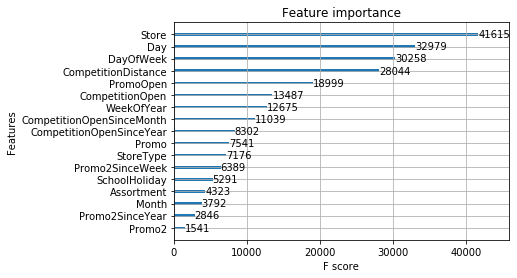

In [52]:
#模型特征重要性
xgb.plot_importance(gbm)
# - 从模型特征重要性分析，比较重要的特征有四类包括1.周期性特征'Day'，'DayOfWeek'，'WeekOfYera'，'Month'等，可见店铺的销售额与时间是息息相关的，尤其是周期较短的时间特征；2.店铺差异'Store'和'StoreTyp'特征，不同店铺的销售额存在特异性；3.短期促销（Promo)情况:'PromoOpen'和'Promo'特征，促销时间的长短与营业额相关性比较大；4.竞争对手相关特征包括：'CompetitionOpen'，‘CompetitionDistance'，'CompetitionOpenSinceMoth'以及'CompetitionOpenScinceyear'，竞争者的距离与营业年限对销售额有影响。
# - 作用不大的特征主要两类包括：1.假期特征：'SchoolHoliday'和'StateHoliday'，假期对销售额影响不大，有可能是假期店铺大多不营业，对模型预测没有太大帮助。2.持续促销(Promo2)相关的特征：'Promo2'，'Prom2SinceYear'以及'Prom2SinceWeek'等特征，有可能持续的促销活动对短期的销售额影响有限。


In [53]:
#采用新的权值融合模型构建保留数据集预测结果
res1 = pd.DataFrame(data = ho_ytest)
res1['Prediction']=bagged_ho_preds2
res1 = pd.merge(ho_xtest,res1, left_index= True, right_index=True)
res1['Ratio'] = res1.Prediction/res.Sales
res1['Error'] =abs(res1.Ratio-1)
res1.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,...,7,31,31,82.0,24187.75,1.0,8.568646,8.568202,0.999948,0.000052
1,1,3,1,0,1,3,1,1270.0,9.0,2008.0,...,7,30,31,82.0,24187.75,1.0,8.521384,8.495686,0.996984,0.003016
2,1,2,1,0,1,3,1,1270.0,9.0,2008.0,...,7,29,31,82.0,24187.75,1.0,8.472823,8.480690,1.000928,0.000928
3,1,1,1,0,1,3,1,1270.0,9.0,2008.0,...,7,28,31,82.0,24187.75,1.0,8.519590,8.528154,1.001005,0.001005
4,1,0,1,0,1,3,1,1270.0,9.0,2008.0,...,7,27,31,82.0,24187.75,1.0,8.716536,8.658512,0.993343,0.006657


In [54]:
#分析偏差最大的10个预测结果与初始模型差异
res1.sort_values(['Error'],ascending=False,inplace= True)
res['Store_new'] = res1['Store']
res['Error_new'] = res1['Error']
res['Ratio_new'] = res1['Ratio']
col_3 = ['Store','Ratio','Error','Store_new','Ratio_new','Error_new']
com = pd.DataFrame(res,columns = col_3)
com[:10]


,Store,Ratio,Error,Store_new,Ratio_new,Error_new
264207,292,1.162414,0.162414,292,1.157037,0.157037
711449,782,1.102852,0.102852,782,1.093553,0.093553
264213,292,1.080666,0.080666,292,1.069271,0.069271
456286,501,1.079322,0.079322,501,1.064904,0.064904
937688,1029,1.078703,0.078703,1029,1.058257,0.058257
937667,1029,1.076170,0.076170,1029,1.060119,0.060119
165039,183,0.923866,0.076134,183,0.913065,0.086935
818909,899,1.072484,0.072484,899,1.051540,0.051540
440257,483,1.069659,0.069659,483,1.054736,0.054736
264218,292,0.933997,0.066003,292,0.922158,0.077842
